# Aston Martin BVAS Analysis Notebook
## Introduction
Benchmarking competitor vehicles provides valuable insight into current market demands and customer expectations. It also allows us to evaluate our own vehicle’s performance in comparison — identifying areas where we excel and where improvement is needed.

This analysis uses data collected from the **BVAT (Benchmark Vehicle Analysis Tool)** Prototype – Level 2. While this prototype setup may introduce minor inaccuracies, it serves as an initial proof-of-concept. If BVAT is selected as our primary data collection tool, it will be equipped with a dedicated chassis and a refined circuit design to ensure higher accuracy.

This notebook demonstrates how the collected data is monitored and explored, focusing specifically on **ACC (Adaptive Cruise Control)** and **AEB (Autonomous Emergency Braking)** behaviour. The analysis is based on:

Acceleration data across three axes (X, Y, Z) by Accelerometer Sensor

Speed data from the onboard GPS sensor

## Data Source
- **Dataset**: Collected using the BVAT Prototype – Level 2

- **Note**: Due to the experimental setup, sensor data may have some level of noise or drift, which will be considered during analysis.

## Objective
### Dataset #1
The goal of this analysis is to assess whether **Dataset #1** contains sufficient information to evaluate the performance of the **ACC (Adaptive Cruise Control)** feature.

Key steps include:

- **Data Availability Check**: Ensure that acceleration and speed data are reliable for identifying driving patterns.

- **Driving Mode Classification**: Using defined thresholds, the dataset will be analyzed to detect key driving behaviors such as:

    - **Acceleration**

    - **Deceleration**

    - **Cruising**

**Comparative Analysis**: Extracted driving mode segments will be evaluated using average values to identify behavioural trends and support ACC performance interpretation.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
import warnings

warnings.filterwarnings('ignore')

In [30]:
dataset1 = pd.read_csv('logs/datalog_20250618_142153.csv')

# Print the first 5 rows of the dataset
print(dataset1.head())

# Print the last 5 rows of the dataset
print(dataset1.tail())

                 Timestamp  Accel_X_g  Accel_Y_g  Accel_Z_g  GPS_Fix  \
0  2025-06-18 14:21:53.280       52.0      -56.0     1048.0        1   
1  2025-06-18 14:21:54.250      132.0      108.0     1003.0        1   
2  2025-06-18 14:21:55.232      184.0       52.0     1064.0        1   
3  2025-06-18 14:21:56.213       64.0      156.0     1052.0        1   
4  2025-06-18 14:21:57.198       84.0      180.0      980.0        1   

   Speed_kmh  
0       77.0  
1       79.0  
2       79.0  
3       79.0  
4       77.0  
                   Timestamp  Accel_X_g  Accel_Y_g  Accel_Z_g  GPS_Fix  \
935  2025-06-18 14:37:10.842       24.0       -8.0     1024.0        1   
936  2025-06-18 14:37:11.830        0.0       -8.0     1016.0        1   
937  2025-06-18 14:37:12.812       -4.0      -36.0     1084.0        1   
938  2025-06-18 14:37:13.789       88.0      -36.0     1048.0        1   
939  2025-06-18 14:37:14.771       32.0       16.0     1036.0        1   

     Speed_kmh  
935       12.0 

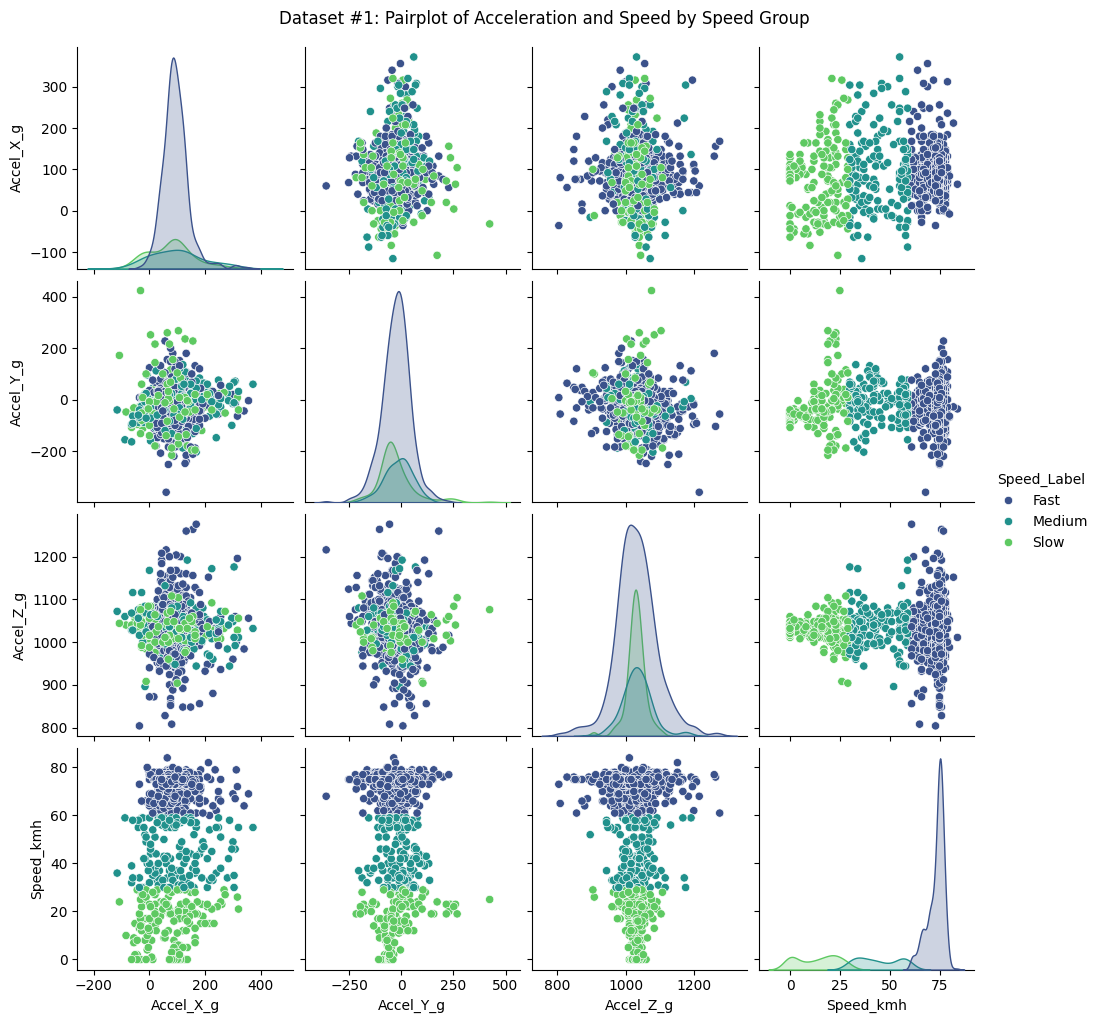

In [31]:
def label_speed(speed):
    if speed < 30:
        return 'Slow'
    elif speed < 60:
        return 'Medium'
    else:
        return 'Fast'

dataset1['Speed_Label'] = dataset1['Speed_kmh'].apply(label_speed)

# Then plot using speed label as hue
sns.pairplot(dataset1, vars=['Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'Speed_kmh'], hue='Speed_Label', palette='viridis')
plt.suptitle('Dataset #1: Pairplot of Acceleration and Speed by Speed Group', y=1.02)
plt.show()

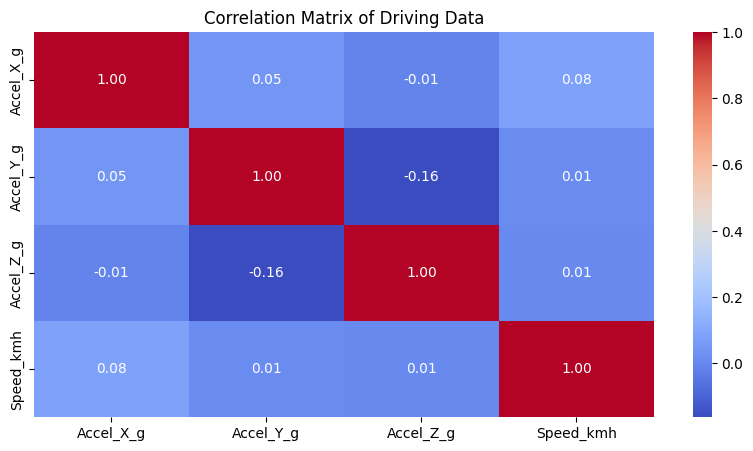

In [32]:
# Select numeric columns to include in the correlation matrix
columns_to_use = ['Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'Speed_kmh']

plt.figure(figsize=(10, 5))
sns.heatmap(
    dataset1[columns_to_use].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Correlation Matrix of Driving Data')
plt.show()

## Categorise driving mode
Applying acceleration and deceleration thresholds allows us to categorize driving behavior into three distinct states: **Accelerating**, **Braking**, and **Cruising**. This threshold-based classification helps make sense of raw sensor data by translating it into interpretable driving actions. It forms the basis for evaluating the performance of features like Adaptive Cruise Control (ACC) by allowing targeted analysis of each state. Ultimately, it enables consistent comparisons across different vehicles or test conditions.

- **Purpose**: Categorise vehicle behavior using longitudinal acceleration thresholds.

- **Classification Logic**:

    - **Accelerating**: Acceleration > Acceleration Threshold

    - **Braking**: Acceleration < Deceleration Threshold

    - **Cruising**: Acceleration between the two thresholds

- **Benefits**:

    - Translates raw sensor data into meaningful driving events.

    - Supports analysis of ACC performance in terms of comfort, responsiveness, and stability.

    - Enables consistent cross-vehicle comparisons for benchmarking purposes.

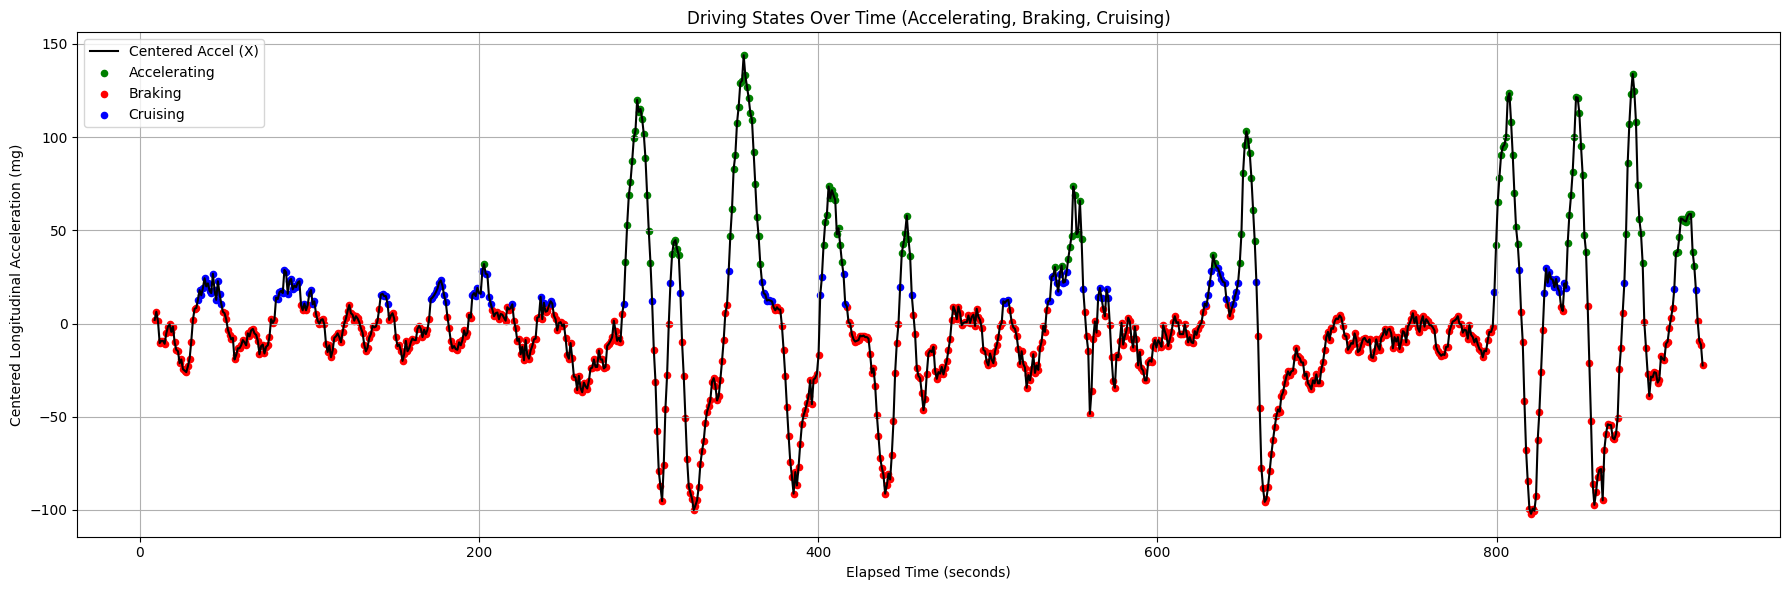

Driving Event Classification Summary
▶ Acceleration Threshold : +30 mg
▶ Braking Threshold      : 10 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Braking                663      70.5%
Cruising               145      15.4%
Accelerating           132      14.0%



In [33]:
# Step 1: Smooth the longitudinal acceleration
dataset1['X_filt'] = dataset1['Accel_X_g'].rolling(window=10).mean()

# Step 2: Center the filtered acceleration around 0
dataset1['X_centered'] = dataset1['X_filt'] - dataset1['X_filt'].mean()

# Step 3: Compute elapsed time in seconds from the start
# Ensure Timestamp is datetime
dataset1['Timestamp'] = pd.to_datetime(dataset1['Timestamp'])

# Calculate elapsed time in seconds
dataset1['Elapsed_s'] = (dataset1['Timestamp'] - dataset1['Timestamp'].iloc[0]).dt.total_seconds()


# Step 4: Define thresholds (in mg) for classification
ACCEL_THRESHOLD = 30   # ~0.2 m/s²
BRAKE_THRESHOLD = 10  # ~-0.2 m/s²

# Step 5: Classify driving states
dataset1['Event'] = 'Cruising'
dataset1.loc[dataset1['X_centered'] > ACCEL_THRESHOLD, 'Event'] = 'Accelerating'
dataset1.loc[dataset1['X_centered'] < BRAKE_THRESHOLD, 'Event'] = 'Braking'

# Step 6: Define event colors
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

# Step 7: Plot
plt.figure(figsize=(18, 6))

# Plot centered acceleration line
plt.plot(dataset1['Elapsed_s'], dataset1['X_centered'], label='Centered Accel (X)', color='black', linewidth=1.5)

# Scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    plt.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

# Formatting
plt.title('Driving States Over Time (Accelerating, Braking, Cruising)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Centered Longitudinal Acceleration (mg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print driving event counts
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

#----------PRINT EVENT COUNTS AND PERCENTAGES-------
# print("Driving Event Counts:")
# event_counts = dataset1['Event'].value_counts()
# print(event_counts)

#-----------SUMMARY OF DRIVING EVENTS-----------
# Step 8: Print driving event counts and percentages
print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)

for event in event_counts.index:
    count = event_counts[event]
    percent = event_percents[event]
    print(f"{event:<15} {count:>10} {percent:>9.1f}%")

print("========================================\n")



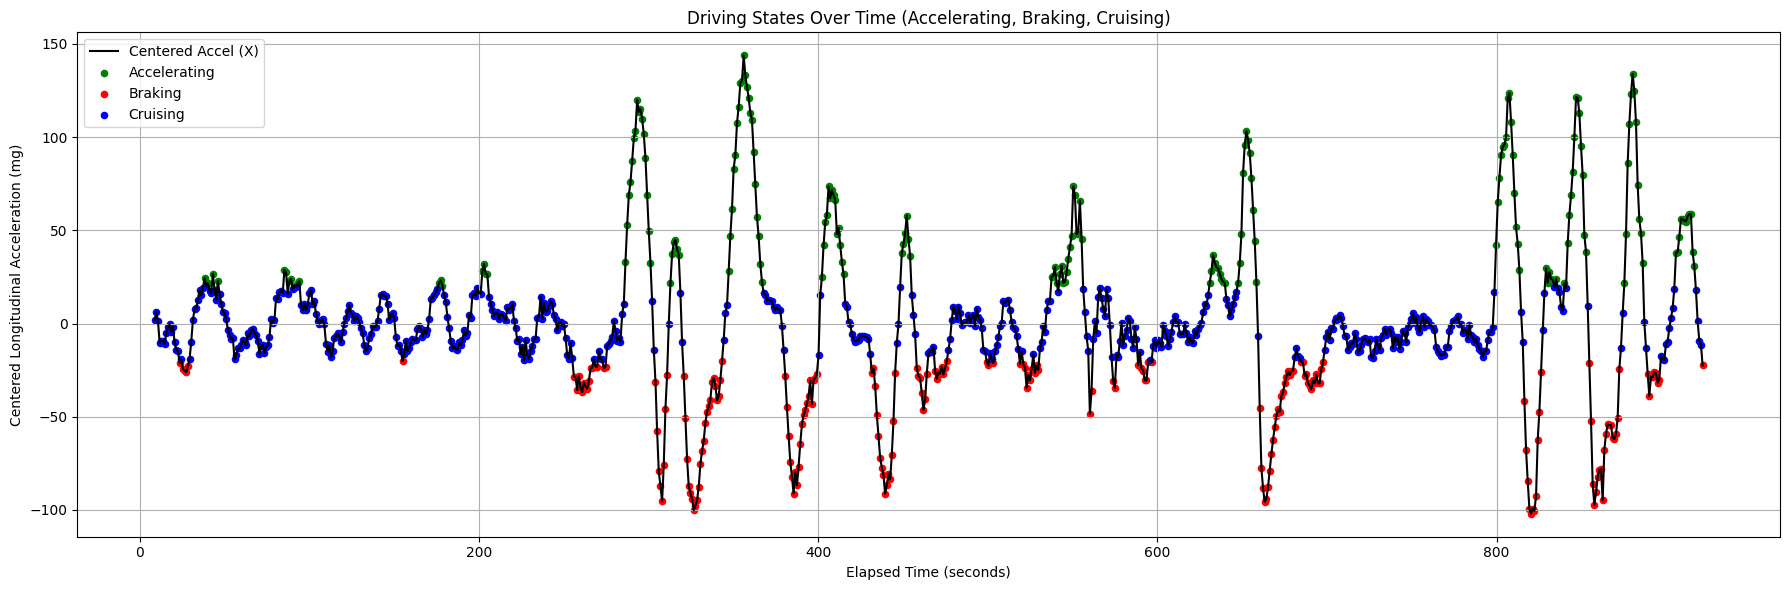

Driving Event Classification Summary
▶ Acceleration Threshold : +20 mg
▶ Braking Threshold      : -20 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               559      59.5%
Braking                202      21.5%
Accelerating           179      19.0%



In [34]:
# Step 1: Smooth the longitudinal acceleration
dataset1['X_filt'] = dataset1['Accel_X_g'].rolling(window=10).mean()

# Step 2: Center the filtered acceleration around 0
dataset1['X_centered'] = dataset1['X_filt'] - dataset1['X_filt'].mean()

# Step 3: Compute elapsed time in seconds from the start
# Ensure Timestamp is datetime
dataset1['Timestamp'] = pd.to_datetime(dataset1['Timestamp'])

# Calculate elapsed time in seconds
dataset1['Elapsed_s'] = (dataset1['Timestamp'] - dataset1['Timestamp'].iloc[0]).dt.total_seconds()


# Step 4: Define thresholds (in mg) for classification
ACCEL_THRESHOLD = 20   # ~0.2 m/s²
BRAKE_THRESHOLD = -20  # ~-0.2 m/s²

# Step 5: Classify driving states
dataset1['Event'] = 'Cruising'
dataset1.loc[dataset1['X_centered'] > ACCEL_THRESHOLD, 'Event'] = 'Accelerating'
dataset1.loc[dataset1['X_centered'] < BRAKE_THRESHOLD, 'Event'] = 'Braking'

# Step 6: Define event colors
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

# Step 7: Plot
plt.figure(figsize=(18, 6))

# Plot centered acceleration line
plt.plot(dataset1['Elapsed_s'], dataset1['X_centered'], label='Centered Accel (X)', color='black', linewidth=1.5)

# Scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    plt.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

# Formatting
plt.title('Driving States Over Time (Accelerating, Braking, Cruising)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Centered Longitudinal Acceleration (mg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print driving event counts
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

#----------PRINT EVENT COUNTS AND PERCENTAGES-------
# print("Driving Event Counts:")
# event_counts = dataset1['Event'].value_counts()
# print(event_counts)

#-----------SUMMARY OF DRIVING EVENTS-----------
# Step 8: Print driving event counts and percentages
print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)

for event in event_counts.index:
    count = event_counts[event]
    percent = event_percents[event]
    print(f"{event:<15} {count:>10} {percent:>9.1f}%")

print("========================================\n")



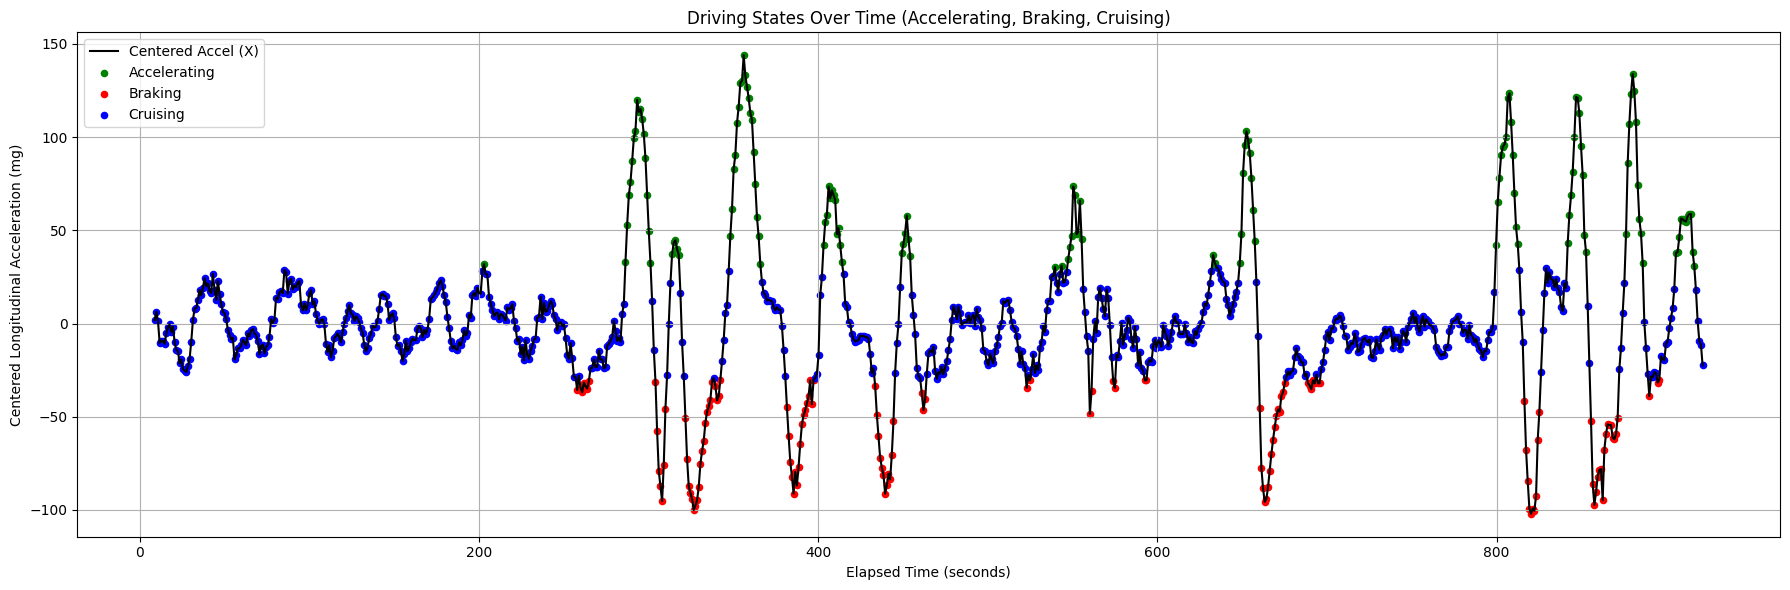

Driving Event Classification Summary
▶ Acceleration Threshold : +30 mg
▶ Braking Threshold      : -30 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               680      72.3%
Accelerating           132      14.0%
Braking                128      13.6%



In [35]:
# Step 1: Smooth the longitudinal acceleration
dataset1['X_filt'] = dataset1['Accel_X_g'].rolling(window=10).mean()

# Step 2: Center the filtered acceleration around 0
dataset1['X_centered'] = dataset1['X_filt'] - dataset1['X_filt'].mean()

# Step 3: Compute elapsed time in seconds from the start
# Ensure Timestamp is datetime
dataset1['Timestamp'] = pd.to_datetime(dataset1['Timestamp'])

# Calculate elapsed time in seconds
dataset1['Elapsed_s'] = (dataset1['Timestamp'] - dataset1['Timestamp'].iloc[0]).dt.total_seconds()


# Step 4: Define thresholds (in mg) for classification
ACCEL_THRESHOLD = 30   # ~0.3 m/s²
BRAKE_THRESHOLD = -30  # ~-0.3 m/s²

# Step 5: Classify driving states
dataset1['Event'] = 'Cruising'
dataset1.loc[dataset1['X_centered'] > ACCEL_THRESHOLD, 'Event'] = 'Accelerating'
dataset1.loc[dataset1['X_centered'] < BRAKE_THRESHOLD, 'Event'] = 'Braking'

# Step 6: Define event colors
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

# Step 7: Plot
plt.figure(figsize=(18, 6))

# Plot centered acceleration line
plt.plot(dataset1['Elapsed_s'], dataset1['X_centered'], label='Centered Accel (X)', color='black', linewidth=1.5)

# Scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    plt.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

# Formatting
plt.title('Driving States Over Time (Accelerating, Braking, Cruising)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Centered Longitudinal Acceleration (mg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print driving event counts
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

#----------PRINT EVENT COUNTS AND PERCENTAGES-------
# print("Driving Event Counts:")
# event_counts = dataset1['Event'].value_counts()
# print(event_counts)

#-----------SUMMARY OF DRIVING EVENTS-----------
# Step 8: Print driving event counts and percentages
print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)

for event in event_counts.index:
    count = event_counts[event]
    percent = event_percents[event]
    print(f"{event:<15} {count:>10} {percent:>9.1f}%")

print("========================================\n")



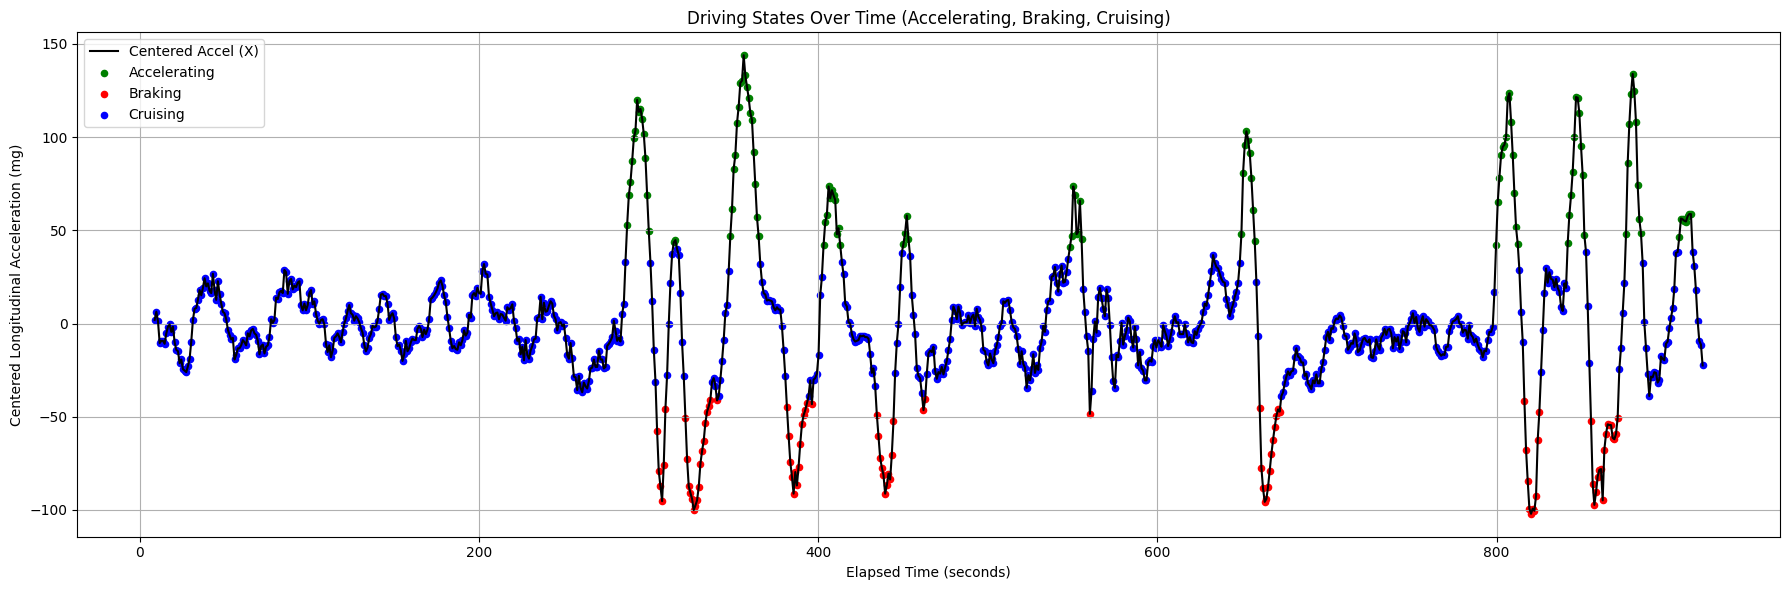

Driving Event Classification Summary
▶ Acceleration Threshold : +40 mg
▶ Braking Threshold      : -40 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               740      78.7%
Accelerating           109      11.6%
Braking                 91       9.7%



In [36]:
# Step 1: Smooth the longitudinal acceleration
dataset1['X_filt'] = dataset1['Accel_X_g'].rolling(window=10).mean()

# Step 2: Center the filtered acceleration around 0
dataset1['X_centered'] = dataset1['X_filt'] - dataset1['X_filt'].mean()

# Step 3: Compute elapsed time in seconds from the start
# Ensure Timestamp is datetime
dataset1['Timestamp'] = pd.to_datetime(dataset1['Timestamp'])

# Calculate elapsed time in seconds
dataset1['Elapsed_s'] = (dataset1['Timestamp'] - dataset1['Timestamp'].iloc[0]).dt.total_seconds()


# Step 4: Define thresholds (in mg) for classification
ACCEL_THRESHOLD = 40   # ~0.5 m/s²
BRAKE_THRESHOLD = -40  # ~-0.5 m/s²

# Step 5: Classify driving states
dataset1['Event'] = 'Cruising'
dataset1.loc[dataset1['X_centered'] > ACCEL_THRESHOLD, 'Event'] = 'Accelerating'
dataset1.loc[dataset1['X_centered'] < BRAKE_THRESHOLD, 'Event'] = 'Braking'

# Step 6: Define event colors
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

# Step 7: Plot
plt.figure(figsize=(18, 6))

# Plot centered acceleration line
plt.plot(dataset1['Elapsed_s'], dataset1['X_centered'], label='Centered Accel (X)', color='black', linewidth=1.5)

# Scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    plt.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

# Formatting
plt.title('Driving States Over Time (Accelerating, Braking, Cruising)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Centered Longitudinal Acceleration (mg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print driving event counts
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

#----------PRINT EVENT COUNTS AND PERCENTAGES-------
# print("Driving Event Counts:")
# event_counts = dataset1['Event'].value_counts()
# print(event_counts)

#-----------SUMMARY OF DRIVING EVENTS-----------
# Step 8: Print driving event counts and percentages
print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)

for event in event_counts.index:
    count = event_counts[event]
    percent = event_percents[event]
    print(f"{event:<15} {count:>10} {percent:>9.1f}%")

print("========================================\n")



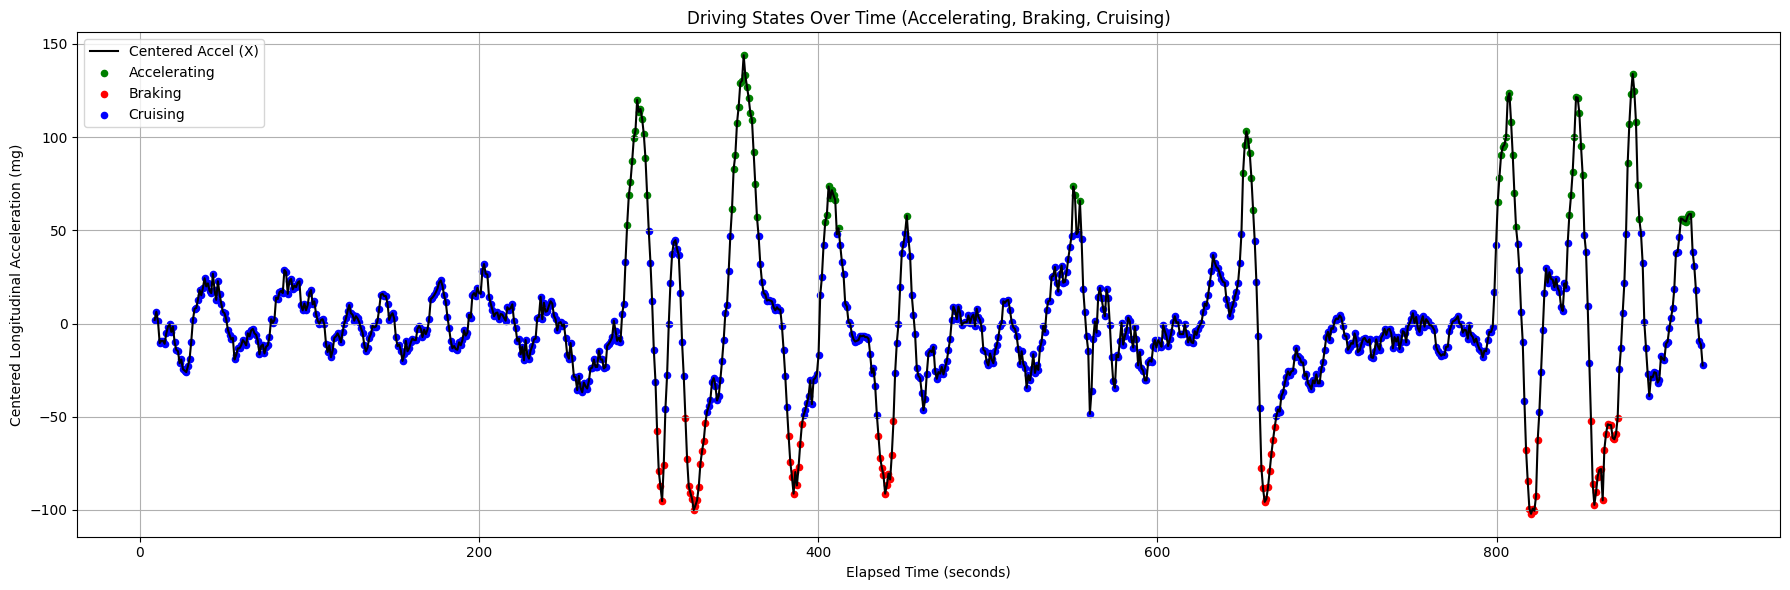

Driving Event Classification Summary
▶ Acceleration Threshold : +50 mg
▶ Braking Threshold      : -50 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               785      83.5%
Accelerating            84       8.9%
Braking                 71       7.6%



In [37]:
# Step 1: Smooth the longitudinal acceleration
dataset1['X_filt'] = dataset1['Accel_X_g'].rolling(window=10).mean()

# Step 2: Center the filtered acceleration around 0
dataset1['X_centered'] = dataset1['X_filt'] - dataset1['X_filt'].mean()

# Step 3: Compute elapsed time in seconds from the start
# Ensure Timestamp is datetime
dataset1['Timestamp'] = pd.to_datetime(dataset1['Timestamp'])

# Calculate elapsed time in seconds
dataset1['Elapsed_s'] = (dataset1['Timestamp'] - dataset1['Timestamp'].iloc[0]).dt.total_seconds()


# Step 4: Define thresholds (in mg) for classification
ACCEL_THRESHOLD = 50   # ~0.5 m/s²
BRAKE_THRESHOLD = -50  # ~-0.5 m/s²

# Step 5: Classify driving states
dataset1['Event'] = 'Cruising'
dataset1.loc[dataset1['X_centered'] > ACCEL_THRESHOLD, 'Event'] = 'Accelerating'
dataset1.loc[dataset1['X_centered'] < BRAKE_THRESHOLD, 'Event'] = 'Braking'

# Step 6: Define event colors
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

# Step 7: Plot
plt.figure(figsize=(18, 6))

# Plot centered acceleration line
plt.plot(dataset1['Elapsed_s'], dataset1['X_centered'], label='Centered Accel (X)', color='black', linewidth=1.5)

# Scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    plt.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

# Formatting
plt.title('Driving States Over Time (Accelerating, Braking, Cruising)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Centered Longitudinal Acceleration (mg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print driving event counts
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

#----------PRINT EVENT COUNTS AND PERCENTAGES-------
# print("Driving Event Counts:")
# event_counts = dataset1['Event'].value_counts()
# print(event_counts)

#-----------SUMMARY OF DRIVING EVENTS-----------
# Step 8: Print driving event counts and percentages
print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)

for event in event_counts.index:
    count = event_counts[event]
    percent = event_percents[event]
    print(f"{event:<15} {count:>10} {percent:>9.1f}%")

print("========================================\n")

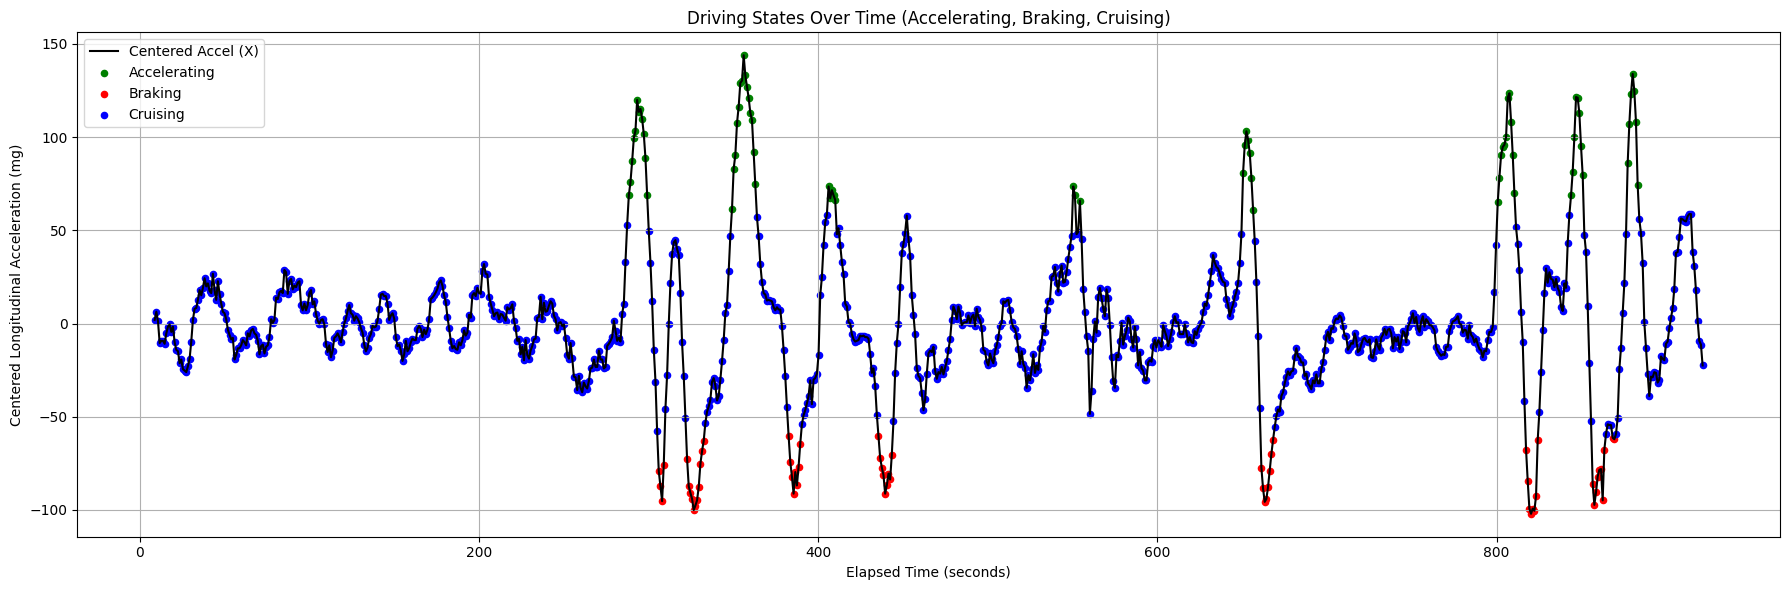

Driving Event Classification Summary
▶ Acceleration Threshold : +60 mg
▶ Braking Threshold      : -60 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               814      86.6%
Accelerating            68       7.2%
Braking                 58       6.2%



In [38]:
# Step 1: Smooth the longitudinal acceleration
dataset1['X_filt'] = dataset1['Accel_X_g'].rolling(window=10).mean()

# Step 2: Center the filtered acceleration around 0
dataset1['X_centered'] = dataset1['X_filt'] - dataset1['X_filt'].mean()

# Step 3: Compute elapsed time in seconds from the start
# Ensure Timestamp is datetime
dataset1['Timestamp'] = pd.to_datetime(dataset1['Timestamp'])

# Calculate elapsed time in seconds
dataset1['Elapsed_s'] = (dataset1['Timestamp'] - dataset1['Timestamp'].iloc[0]).dt.total_seconds()


# Step 4: Define thresholds (in mg) for classification
ACCEL_THRESHOLD = 60   # ~0.5 m/s²
BRAKE_THRESHOLD = -60  # ~-0.5 m/s²

# Step 5: Classify driving states
dataset1['Event'] = 'Cruising'
dataset1.loc[dataset1['X_centered'] > ACCEL_THRESHOLD, 'Event'] = 'Accelerating'
dataset1.loc[dataset1['X_centered'] < BRAKE_THRESHOLD, 'Event'] = 'Braking'

# Step 6: Define event colors
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

# Step 7: Plot
plt.figure(figsize=(18, 6))

# Plot centered acceleration line
plt.plot(dataset1['Elapsed_s'], dataset1['X_centered'], label='Centered Accel (X)', color='black', linewidth=1.5)

# Scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    plt.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

# Formatting
plt.title('Driving States Over Time (Accelerating, Braking, Cruising)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Centered Longitudinal Acceleration (mg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print driving event counts
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

#----------PRINT EVENT COUNTS AND PERCENTAGES-------
# print("Driving Event Counts:")
# event_counts = dataset1['Event'].value_counts()
# print(event_counts)

#-----------SUMMARY OF DRIVING EVENTS-----------
# Step 8: Print driving event counts and percentages
print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)

for event in event_counts.index:
    count = event_counts[event]
    percent = event_percents[event]
    print(f"{event:<15} {count:>10} {percent:>9.1f}%")

print("========================================\n")



## Target Threshold: –20 mg to +20 mg

The threshold range of –20 mg to +20 mg is selected to effectively categorise vehicle behavior and analyse the performance of the Adaptive Cruise Control (ACC) system.

This range aims to strike a balance between sensitivity and noise filtering, helping to identify genuine acceleration and braking events without overreacting to minor fluctuations.

The diagram below visualises how acceleration data is classified into driving states using this threshold, alongside the corresponding vehicle speed profile.

Driving Event Classification Summary
▶ Acceleration Threshold : +20 mg
▶ Braking Threshold      : -20 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               559      59.5%
Braking                202      21.5%
Accelerating           179      19.0%



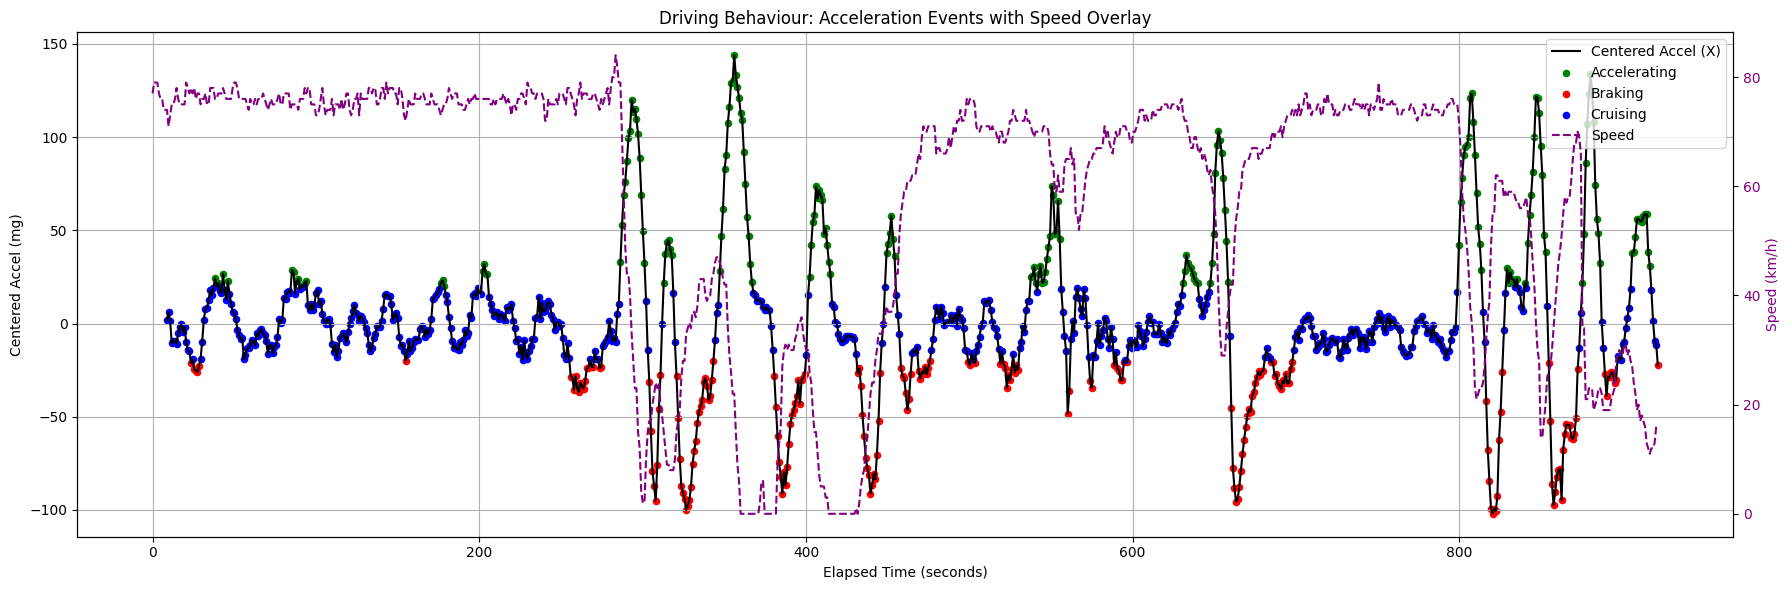

In [39]:
# -------------------------------------------------------
# Step 1: Define function to classify driving events
# -------------------------------------------------------
def classify_driving_events(df, accel_column='X_centered', accel_thresh=50, brake_thresh=-50):
    """
    Classify driving states (Accelerating, Braking, Cruising) based on centered acceleration.
    
    Parameters:
        df (pd.DataFrame): DataFrame with an acceleration column.
        accel_column (str): Name of the acceleration column to use.
        accel_thresh (float): Threshold (mg) above which is Accelerating.
        brake_thresh (float): Threshold (mg) below which is Braking.
        
    Returns:
        pd.Series: Series with labels 'Accelerating', 'Braking', or 'Cruising'
    """
    event = pd.Series(['Cruising'] * len(df), index=df.index)
    event[df[accel_column] > accel_thresh] = 'Accelerating'
    event[df[accel_column] < brake_thresh] = 'Braking'
    return event


# -------------------------------------------------------
# Step 2: Set thresholds and apply classification
# -------------------------------------------------------
ACCEL_THRESHOLD = 20  # mg
BRAKE_THRESHOLD = -20  # mg

dataset1['Event'] = classify_driving_events(
    dataset1,
    accel_column='X_centered',
    accel_thresh=ACCEL_THRESHOLD,
    brake_thresh=BRAKE_THRESHOLD
)

# -------------------------------------------------------
# Step 3: Print event summary
# -------------------------------------------------------
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)
for event in event_counts.index:
    print(f"{event:<15} {event_counts[event]:>10} {event_percents[event]:>9.1f}%")
print("========================================\n")

# -------------------------------------------------------
# Step 4: Plot acceleration events with speed overlay
# -------------------------------------------------------
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot centered acceleration on primary y-axis
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Centered Accel (mg)', color='black')
ax1.plot(dataset1['Elapsed_s'], dataset1['X_centered'], color='black', label='Centered Accel (X)', linewidth=1.5)

# Add scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    ax1.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Plot speed on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Speed (km/h)', color='purple')
ax2.plot(dataset1['Elapsed_s'], dataset1['Speed_kmh'], color='purple', linestyle='--', label='Speed', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor='purple')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Final formatting
plt.title('Driving Behaviour: Acceleration Events with Speed Overlay')
plt.tight_layout()
plt.show()

## Analysis - Set windows

Since during the test driving, the data can be different depends on the road conditions, the number of cars on the road, it might need to turn the ACC feature off which causes the data is not always reliable.
To ensure handling the exact parts only when the ACC is turned on, the speed data shows a solid trend that the speed are within standard deviation value of 3. Detecting this feature, it can be handle only when the ACC is turned on. 

Assuming that when the ACC is turned on, the windows are divided dynamically, acceleration data are already classified into three different states by Acceleration, Braking, and Cruising, it will be start to statistically approach to the data by counting the number of each state within each window. Then it will calculates the accelerometer's statistical values like mean, and standard deviation to see the trend.

In [40]:
def find_dynamic_stable_speed_segments(df, speed_col='Speed_kmh', time_col='Elapsed_s',
                                       rolling_window=5, std_threshold=2.0, min_duration=30):
    """
    Dynamically detect continuous stable-speed segments.
    
    Parameters:
        df (pd.DataFrame): Must contain speed and time columns.
        speed_col (str): Column name for speed (e.g. 'Speed_kmh').
        time_col (str): Column for time in seconds (e.g. 'Elapsed_s').
        rolling_window (int): Window size in seconds for rolling std dev.
        std_threshold (float): Max allowed std dev to call speed 'stable'.
        min_duration (int): Minimum duration (in seconds) for a segment to be valid.
        
    Returns:
        List of (start_time, end_time, segment_df)
    """
    df = df.copy()
    
    # Rolling std dev
    df['Speed_Std'] = df[speed_col].rolling(window=rolling_window, min_periods=1).std()

    # Mark where it's stable
    df['Stable'] = df['Speed_Std'] < std_threshold

    segments = []
    in_segment = False
    segment_start = None

    for i in range(len(df)):
        if df['Stable'].iloc[i] and not in_segment:
            in_segment = True
            segment_start = df[time_col].iloc[i]

        elif not df['Stable'].iloc[i] and in_segment:
            segment_end = df[time_col].iloc[i]
            duration = segment_end - segment_start

            if duration >= min_duration:
                seg_df = df[(df[time_col] >= segment_start) & (df[time_col] < segment_end)]
                segments.append((segment_start, segment_end, seg_df))
            
            in_segment = False

    # Handle case where end of data is still stable
    if in_segment:
        segment_end = df[time_col].iloc[-1]
        duration = segment_end - segment_start
        if duration >= min_duration:
            seg_df = df[(df[time_col] >= segment_start) & (df[time_col] <= segment_end)]
            segments.append((segment_start, segment_end, seg_df))

    return segments

segments = find_dynamic_stable_speed_segments(
    dataset1,
    rolling_window=5,       # seconds
    std_threshold=3.0,      # tighter = more selective
    min_duration=30         # seconds
)

print(f"Stable segments found: {len(segments)}")
for i, (start, end, _) in enumerate(segments):
    print(f"Segment {i+1}: {start:.1f}s to {end:.1f}s ({end - start:.1f}s)")

Stable segments found: 4
Segment 1: 1.0s to 283.5s (282.5s)
Segment 2: 462.1s to 550.4s (88.3s)
Segment 3: 574.0s to 650.5s (76.6s)
Segment 4: 669.2s to 800.7s (131.5s)


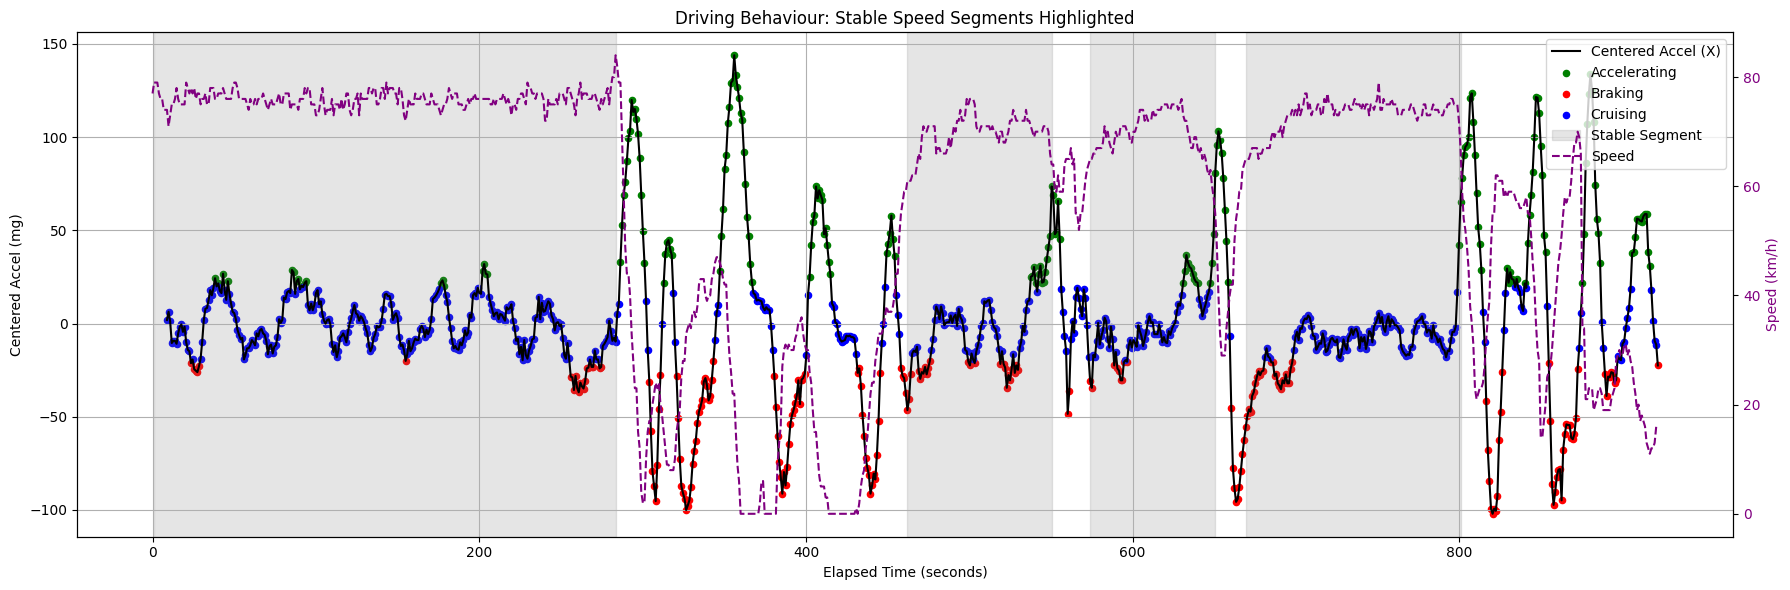

In [41]:
def plot_stable_segments(df, stable_segments, accel_col='X_centered', speed_col='Speed_kmh',
                         time_col='Elapsed_s', event_col='Event'):
    """
    Plot acceleration and speed with highlighted stable-speed segments.
    
    Parameters:
        df (DataFrame): Full dataset with acceleration, speed, event, and time columns.
        stable_segments (list): Output from find_dynamic_stable_speed_segments().
        accel_col (str): Name of centered acceleration column.
        speed_col (str): Name of speed column.
        time_col (str): Elapsed time column (in seconds).
        event_col (str): Event classification column.
    """
    fig, ax1 = plt.subplots(figsize=(18, 6))

    # Plot centered acceleration
    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('Centered Accel (mg)', color='black')
    ax1.plot(df[time_col], df[accel_col], color='black', label='Centered Accel (X)', linewidth=1.5)

    # Color scatter points by event
    event_colors = {'Accelerating': 'green', 'Braking': 'red', 'Cruising': 'blue'}
    for event, color in event_colors.items():
        mask = df[event_col] == event
        ax1.scatter(df[time_col][mask], df[accel_col][mask], color=color, s=20, label=event)

    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True)

    # Add shaded stable segments
    for start, end, _ in stable_segments:
        ax1.axvspan(start, end, color='gray', alpha=0.2, label='Stable Segment')

    # Plot speed on second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Speed (km/h)', color='purple')
    ax2.plot(df[time_col], df[speed_col], linestyle='--', color='purple', label='Speed', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor='purple')

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    seen = set()
    final_labels = []
    final_handles = []
    for h, l in zip(handles1 + handles2, labels1 + labels2):
        if l not in seen:
            seen.add(l)
            final_labels.append(l)
            final_handles.append(h)

    ax1.legend(final_handles, final_labels, loc='upper right')

    plt.title('Driving Behaviour: Stable Speed Segments Highlighted')
    plt.tight_layout()
    plt.show()

plot_stable_segments(dataset1, segments)

In [42]:
def statistics_segment(segment_df):
    """
    Compute combined speed and acceleration statistics for a segment.
    """
    duration = segment_df['Elapsed_s'].max() - segment_df['Elapsed_s'].min()
    
    # Speed stats
    mean_speed = segment_df['Speed_kmh'].mean()
    std_speed = segment_df['Speed_kmh'].std()
    min_speed = segment_df['Speed_kmh'].min()
    max_speed = segment_df['Speed_kmh'].max()

    # Acceleration stats
    mean_accel = segment_df['X_centered'].mean()
    std_accel = segment_df['X_centered'].std()
    min_accel = segment_df['X_centered'].min()
    max_accel = segment_df['X_centered'].max()

    # Driving event counts
    event_counts = segment_df['Event'].value_counts()
    accel_count = event_counts.get('Accelerating', 0)
    brake_count = event_counts.get('Braking', 0)
    cruise_count = event_counts.get('Cruising', 0)

    return {
        'Start Time (s)': segment_df['Elapsed_s'].min(),
        'End Time (s)': segment_df['Elapsed_s'].max(),
        'Duration (s)': duration,
        'Mean Speed (km/h)': mean_speed,
        'Std Speed (km/h)': std_speed,
        'Min Speed (km/h)': min_speed,
        'Max Speed (km/h)': max_speed,
        'Mean Accel (mg)': mean_accel,
        'Std Accel (mg)': std_accel,
        'Min Accel (mg)': min_accel,
        'Max Accel (mg)': max_accel,
        'Accelerating Count': accel_count,
        'Braking Count': brake_count,
        'Cruising Count': cruise_count
    }

def summarise_all_segments(segments):
    """
    Generate full statistics (speed + acceleration + event counts) for all segments.
    """
    summary_list = []

    for i, (_, _, seg_df) in enumerate(segments):
        stats = statistics_segment(seg_df)
        stats['Segment'] = f"Segment {i+1}"
        summary_list.append(stats)
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_list)
    
    # Optional: Rearranged column order
    column_order = [
        'Segment', 'Start Time (s)', 'End Time (s)', 'Duration (s)',
        'Mean Speed (km/h)', 'Std Speed (km/h)', 'Min Speed (km/h)', 'Max Speed (km/h)',
        'Mean Accel (mg)', 'Std Accel (mg)', 'Min Accel (mg)', 'Max Accel (mg)',
        'Accelerating Count', 'Braking Count', 'Cruising Count'
    ]
    
    return summary_df[column_order]

summary_df = summarise_all_segments(segments)
display(summary_df)

,Segment,Start Time (s),End Time (s),Duration (s),Mean Speed (km/h),Std Speed (km/h),Min Speed (km/h),Max Speed (km/h),Mean Accel (mg),Std Accel (mg),Min Accel (mg),Max Accel (mg),Accelerating Count,Braking Count,Cruising Count
0,Segment 1,0.970,282.504,281.534,75.965278,1.474112,71.0,80.0,-1.334780,14.122442,-36.883351,31.916649,18,22,248
1,Segment 2,462.112,549.428,87.316,69.833333,3.342777,61.0,76.0,-4.292240,19.175849,-46.483351,47.116649,12,24,54
2,Segment 3,573.968,649.568,75.600,69.948718,3.920964,58.0,76.0,-0.575659,17.268414,-34.483351,47.916649,13,9,56
3,Segment 4,669.194,799.718,130.524,73.067164,2.946127,65.0,79.0,-11.232605,13.269801,-55.683351,42.316649,1,26,107


In [43]:
def get_event_percentage_table(summary_df):
    """
    Returns a new DataFrame showing only the percentage of each driving event per segment.

    Parameters:
        summary_df (pd.DataFrame): DataFrame with event counts per segment.

    Returns:
        pd.DataFrame: Table with % Accelerating, % Braking, % Cruising for each segment.
    """
    percentage_rows = []

    for _, row in summary_df.iterrows():
        total = row['Accelerating Count'] + row['Braking Count'] + row['Cruising Count']
        if total > 0:
            acc_pct = round(row['Accelerating Count'] / total * 100, 1)
            brake_pct = round(row['Braking Count'] / total * 100, 1)
            cruise_pct = round(row['Cruising Count'] / total * 100, 1)
        else:
            acc_pct = brake_pct = cruise_pct = 0.0

        percentage_rows.append({
            'Segment': row['Segment'],
            '% Accelerating': acc_pct,
            '% Braking': brake_pct,
            '% Cruising': cruise_pct
        })

    return pd.DataFrame(percentage_rows)

percentage_table = get_event_percentage_table(summary_df)
display(percentage_table)

,Segment,% Accelerating,% Braking,% Cruising
0,Segment 1,6.2,7.6,86.1
1,Segment 2,13.3,26.7,60.0
2,Segment 3,16.7,11.5,71.8
3,Segment 4,0.7,19.4,79.9


In [44]:
def compute_overall_event_percentages(summary_df):
    """
    Compute the overall percentages of Accelerating, Braking, and Cruising across all segments.

    Parameters:
        summary_df (pd.DataFrame): Must contain Accelerating/Braking/Cruising Count columns.

    Returns:
        dict: Overall % Accelerating, % Braking, % Cruising
    """
    total_acc = summary_df['Accelerating Count'].sum()
    total_brake = summary_df['Braking Count'].sum()
    total_cruise = summary_df['Cruising Count'].sum()

    total = total_acc + total_brake + total_cruise

    if total == 0:
        return {'% Accelerating': 0.0, '%Braking': 0.0, '% Cruising': 0.0}

    return {
        '% Accelerating': round(total_acc / total * 100, 1),
        '% Braking': round(total_brake / total * 100, 1),
        '% Cruising': round(total_cruise / total * 100, 1)
    }


overall_percentages = compute_overall_event_percentages(summary_df)
print("Overall Driving Event Percentages (Stable Segments Only):")
for event, pct in overall_percentages.items():
    print(f"{event}: {pct}%")

Overall Driving Event Percentages (Stable Segments Only):
% Accelerating: 7.5%
% Braking: 13.7%
% Cruising: 78.8%


## KPIs Reviews
|Targets|Unit|KPIs (Value/Rage)|Accuracy|Details|Associated with|Status|
|:-----:|:--:|:---------------:|:------:|:-----:|:-------------:|:----:|
|Acceleration|%|60-70|1%|...|Accelerometer||
|Brake Pressure|%|5-10|1%|...|Accelerometer||
|Lateral Accceleration|m/s2|2.5-3|0.1|...|Accelerometer||
|Acceleration Profile - small (0-20 mph)|X|X|X|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Acceleration Profile - medium (20-40 mph)|X|X|X|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Acceleration Profile - high (40-60 mph)|X|X|X|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Stop & Go Accel consistency|X|X|X|...|Accelerometer, GPS|O|
|Stop & Go Accel Profile|X|X|X|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Decelearation Profile - small (0-20 mph)|X|X|X|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Decelearation Profile - medium (20-40 mph)|X|X|X|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Decelearation Profile - high (40-60 mph)|X|X|X|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Stop & Go Decel consistency|X|X|`std(1)`|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Stop & Go Decel consistency|X|X|`std(1)`|...|Accelerometer, GPS|O|
|Stop & Go Decel Profile|X|X|`std(1)`|Vehicle Longitudinal speed, Vehicle longitudinal acceleration|Accelerometer, GPS|O|
|Speed Controller Accuracy - No Lead Vehicle, speed < 50 mph, flat road|X|X|X|...|GPS|O|
|Speed Controller Accuracy - No Lead Vehicle, speed > 50 mph, flat road|X|X|X|...|GPS|O|
|Speed Controller Accuracy - no lead Vehicle, driving uphill|X|X|X|...|GPS|O|
|Speed Controller Accuracy - No Lead Vehicle, driving downhill|X|X|X|...|GPS|O|

## Acceleration/Deceleration Profile Analysis

In [45]:
print(dataset1.columns)

Index(['Timestamp', 'Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'GPS_Fix',
       'Speed_kmh', 'Speed_Label', 'X_filt', 'X_centered', 'Elapsed_s',
       'Event'],
      dtype='object')


In [46]:
def extract_profiles(df, profile, direction='acceleration', display_plots=True):
    """
    Extract segments for acceleration or deceleration profile between defined speed ranges.
    
    Parameters:
        df : DataFrame with driving data
        profile : 'small', 'medium', or 'large'
        direction : 'acceleration' or 'deceleration'
        display_plots : If True, plots will be shown
    """
    speed_ranges = {
        'acceleration': {
            'small': (0.0, 32.19),
            'medium': (32.19, 64.37),
            'large': (64.37, 96.56)
        },
        'deceleration': {
            'small': (32.19, 0.0),
            'medium': (64.37, 32.19),
            'large': (96.56, 64.37)
        }
    }

    if direction not in speed_ranges:
        raise ValueError("Direction must be 'acceleration' or 'deceleration'.")
    if profile not in speed_ranges[direction]:
        raise ValueError("Profile must be 'small', 'medium', or 'large'.")

    start_speed, end_speed = speed_ranges[direction][profile]

    in_segment = False
    segments = []
    start_idx = None

    for i in range(1, len(df)):
        speed_now = df.iloc[i]['Speed_kmh']
        speed_prev = df.iloc[i - 1]['Speed_kmh']

        # Determine start condition
        if direction == 'acceleration':
            if not in_segment and speed_prev < start_speed <= speed_now:
                start_idx = i - 1
                in_segment = True
            elif in_segment and speed_now >= end_speed:
                end_idx = i
                segment = df.iloc[start_idx:end_idx + 1].copy()
                segments.append(segment)
                in_segment = False
        elif direction == 'deceleration':
            if not in_segment and speed_prev > start_speed >= speed_now:
                start_idx = i - 1
                in_segment = True
            elif in_segment and speed_now <= end_speed:
                end_idx = i
                segment = df.iloc[start_idx:end_idx + 1].copy()
                segments.append(segment)
                in_segment = False

    print(f"Found {len(segments)} segments for {direction} profile: {profile}")
    summaries = []

    for idx, segment in enumerate(segments):
        duration = segment['Elapsed_s'].iloc[-1] - segment['Elapsed_s'].iloc[0]
        mean_accel = segment['X_centered'].mean()
        std_accel = segment['X_centered'].std()

        summaries.append({
            'Profile Segment': f'{direction}_{profile}_{idx + 1}',
            'Direction': direction,
            'Mean Acceleration (mg)': mean_accel,
            'Std Acceleration (mg)': std_accel,
            'Duration (s)': duration,
            'Start Speed (km/h)': segment['Speed_kmh'].iloc[0],
            'End Speed (km/h)': segment['Speed_kmh'].iloc[-1],
        })

        if display_plots and len(segment) > 1:
            fig, ax1 = plt.subplots(figsize=(10, 4))
            ax2 = ax1.twinx()

            ax1.plot(segment['Elapsed_s'], segment['Speed_kmh'], 'g-', label='Speed (km/h)')
            ax1.set_ylabel('Speed (km/h)', color='g')
            ax1.tick_params(axis='y', labelcolor='g')

            ax2.plot(segment['Elapsed_s'], segment['X_centered'], 'b-', alpha=0.6, label='Accel (mg)')
            ax2.set_ylabel('Accel (mg)', color='b')
            ax2.tick_params(axis='y', labelcolor='b')

            if segment['Elapsed_s'].nunique() > 1 and segment['X_centered'].notna().all():
                slope, intercept, *_ = linregress(segment['Elapsed_s'], segment['X_centered'])
                trend = slope * segment['Elapsed_s'] + intercept
                ax2.plot(segment['Elapsed_s'], trend, 'r--', label='Accel Trend')

            plt.title(f"{direction.capitalize()} - {profile.capitalize()} Profile Segment {idx + 1}")
            fig.tight_layout()
            fig.legend(loc='upper right')
            plt.show()

    if summaries:
        return pd.DataFrame(summaries).set_index('Profile Segment')
    else:
        return pd.DataFrame()

In [47]:
def analyze_all_profiles(df, display_plots=True):
    """
    Analyze all acceleration and deceleration profiles (small, medium, large).
    Returns a combined summary DataFrame.
    """
    summary_parts = []
    profiles = ['small', 'medium', 'large']
    directions = ['acceleration', 'deceleration']

    for direction in directions:
        for profile in profiles:
            result_df = extract_profiles(df, profile, direction=direction, display_plots=display_plots)
            if not result_df.empty:
                summary_parts.append(result_df)

    if summary_parts:
        combined_summary = pd.concat(summary_parts)
        display(combined_summary)
        return combined_summary
    else:
        print("No valid segments found.")
        return pd.DataFrame()

### Acceleration/Deceleration Profile
The graphs and summary table below provide insights into each driving segment recorded during the test drive. Segments are dynamically identified and classified based on speed thresholds corresponding to small, medium, and large profiles:

- **Small**: 0 – 20 mph

- **Medium**: 20 – 40 mph

- **Large**: 40 – 60 mph

Each graph presents:

- **Speed** (left Y-axis, green line)

- **Acceleration** (right Y-axis, blue line)

- **Linear trend line** for acceleration (red dashed line) to visually highlight general patterns over each segment.

These visualisations make it easier to compare:

- Driving behavior between different segments

- Patterns across different test sessions or datasets

#### How to Interpret Acceleration (mg):
- **+mg**: The vehicle is accelerating (speed increasing faster)

- **0 mg**: The vehicle is cruising (maintaining a constant speed)

- **−mg**: The vehicle is decelerating (slowing down or braking)

Found 0 segments for acceleration profile: small
Found 3 segments for acceleration profile: medium


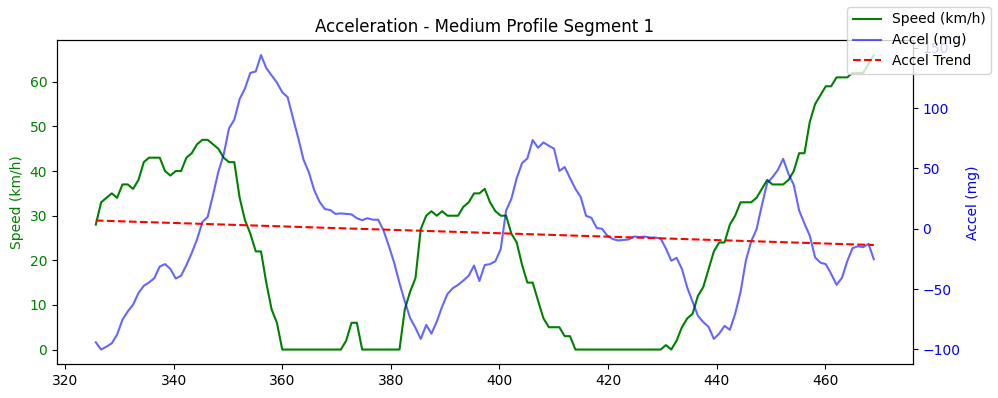

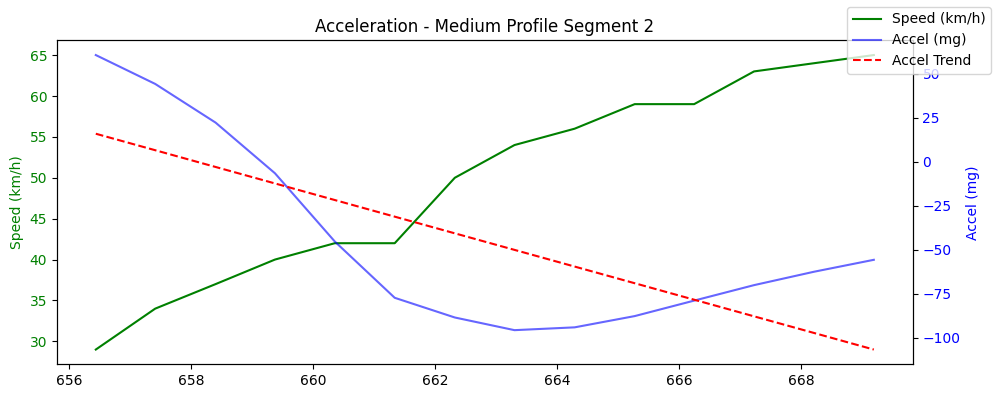

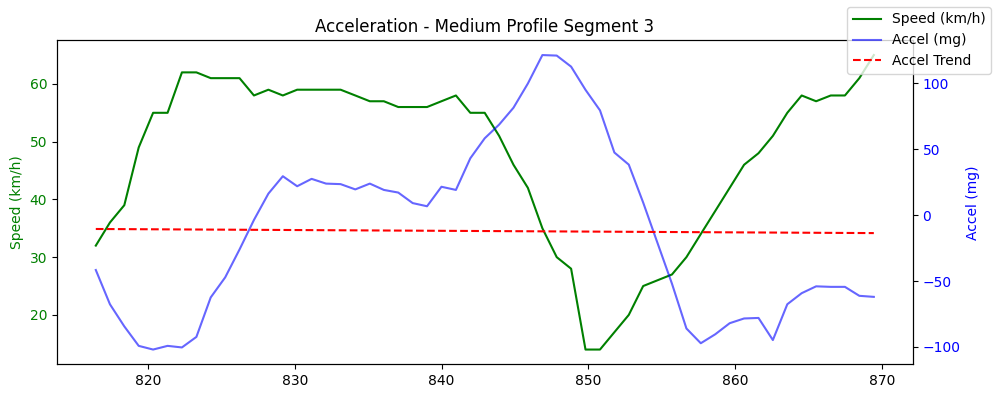

Found 0 segments for acceleration profile: large
Found 2 segments for deceleration profile: small


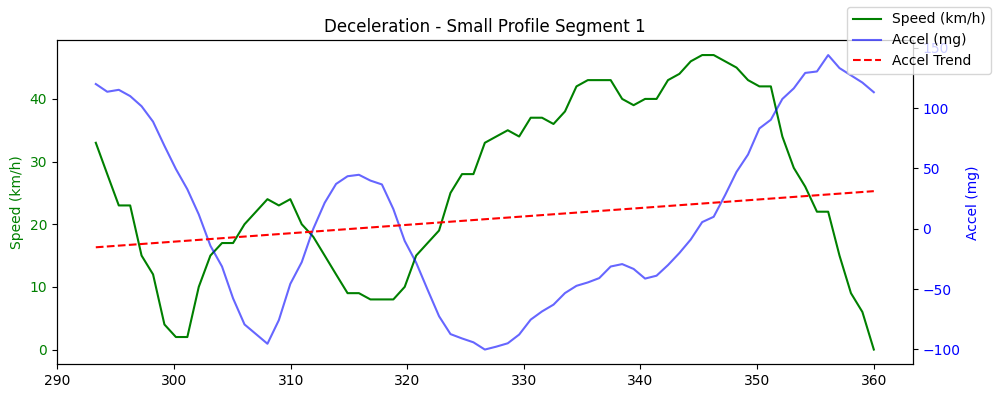

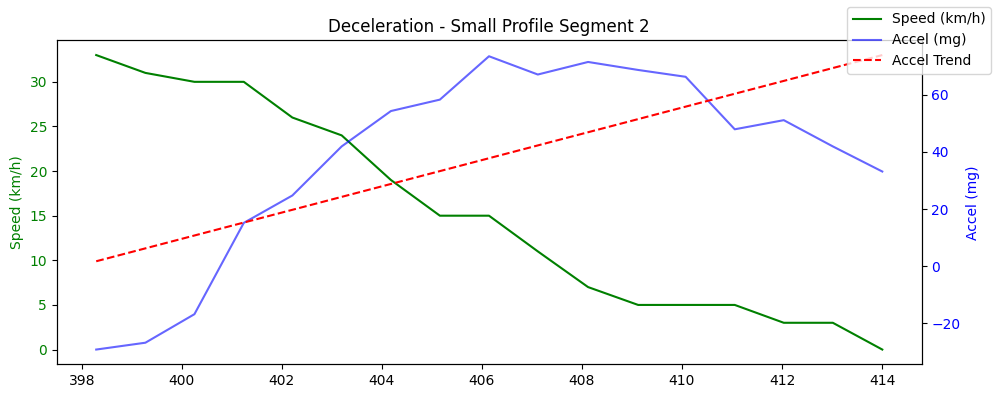

Found 4 segments for deceleration profile: medium


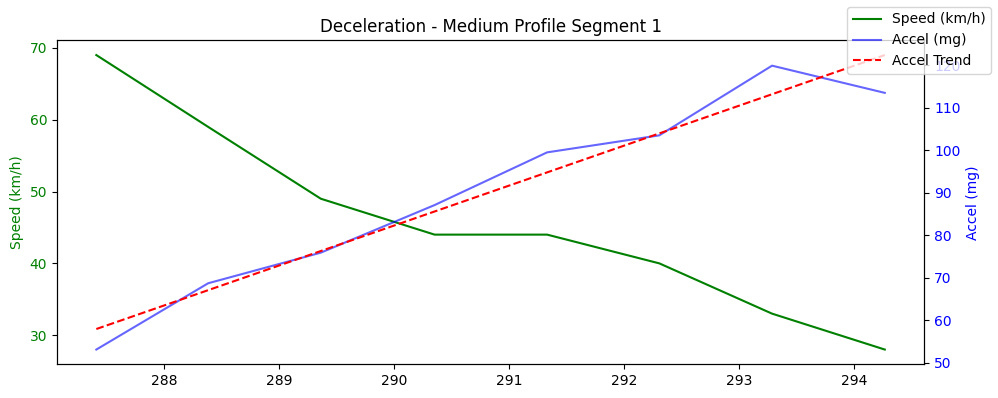

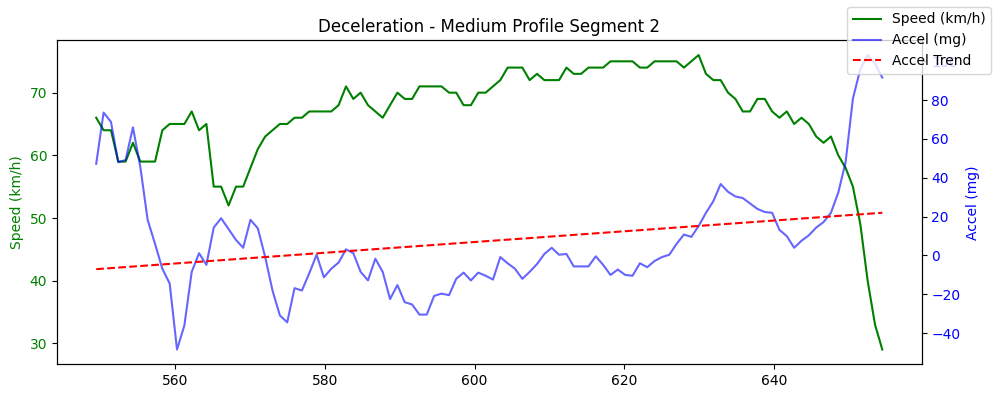

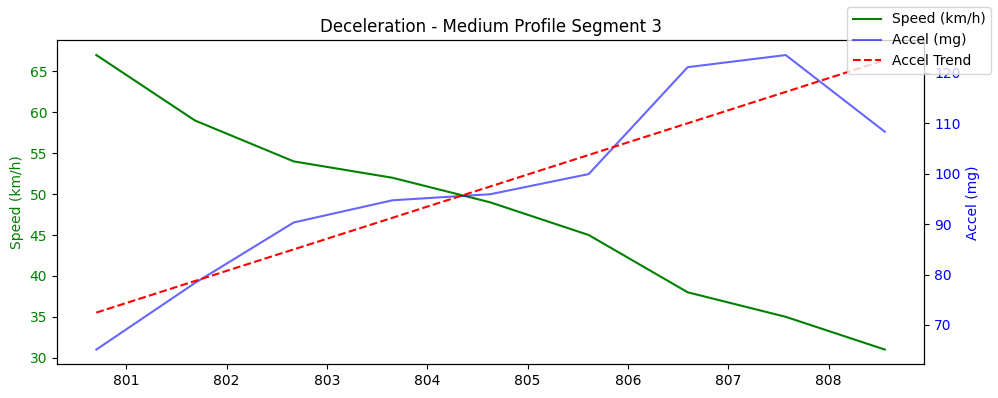

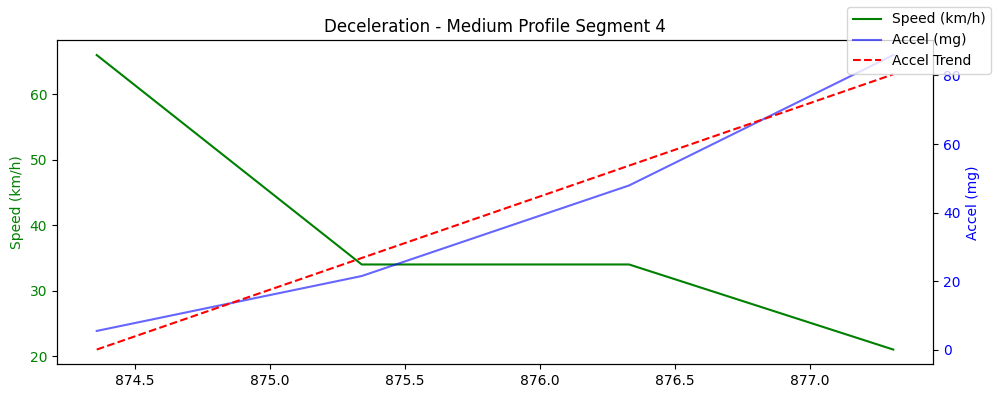

Found 0 segments for deceleration profile: large


,Direction,Mean Acceleration (mg),Std Acceleration (mg),Duration (s),Start Speed (km/h),End Speed (km/h)
Profile Segment,,,,,,
acceleration_medium_1,acceleration,-3.326889,56.632091,143.296,28.0,66.0
acceleration_medium_2,acceleration,-45.340494,53.419180,12.751,29.0,65.0
acceleration_medium_3,acceleration,-12.097897,66.083940,53.020,32.0,65.0
deceleration_small_1,deceleration,7.899257,75.039203,66.726,33.0,0.0
deceleration_small_2,deceleration,37.799002,33.939583,15.718,33.0,0.0
deceleration_medium_1,deceleration,90.166649,23.118020,6.860,69.0,28.0
deceleration_medium_2,deceleration,7.416649,29.171135,105.044,66.0,29.0
deceleration_medium_3,deceleration,97.472204,18.828111,7.856,67.0,31.0
deceleration_medium_4,deceleration,40.216649,35.126248,2.952,66.0,21.0


In [48]:
# Just run this one-liner:
summary_df = analyze_all_profiles(dataset1)

## Stop and Go Analysis

This section analyzes the driving behavior in terms of "Stop" and "Go" events using speed and acceleration data.

### Go Segments
A **Go** segment is identified when the vehicle starts moving from a stopped condition:
- It is detected when the vehicle's speed transitions from approximately **0 km/h** (≤ 1 km/h) to a **moving state** (> 1 km/h).
- After detecting this transition, the next 10 seconds of data are analysed to observe the acceleration pattern.
- Only valid transitions where the speed is **increasing** are considered as Go segments.

### Stop Segments
A **Stop** segment is identified when the vehicle slows down to a full stop:
- It is detected when the speed changes from **above 1 km/h** to **approximately 0 km/h** (≤ 1 km/h).
- The analysis takes the 10 seconds **leading up to** the stop point.
- Only valid transitions where the speed is **decreasing** are considered as Stop segments.

### Visualisation and Summary
Each segment includes:
- Speed and acceleration plots over time.
- Linear trend lines for both speed and acceleration.

- A summary table with:
  - Start and end time of the segment
  - Speed change
  - Acceleration statistics (start, end, mean, standard deviation)

This allows for a clear understanding of vehicle behaviour during stop-and-go scenarios, useful for traffic, comfort, and energy efficiency analysis.

In [49]:
# Check available columns first (optional but helpful)
print(dataset1.columns)

# Detect possible STOP transitions: from speed > 1 to speed <= 1
stop_candidates = dataset1[
    (dataset1['Speed_kmh'].shift(1) > 1) & (dataset1['Speed_kmh'] <= 1)
]

print(f"Detected {len(stop_candidates)} possible stop transition points.")
display(stop_candidates.head())

Index(['Timestamp', 'Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'GPS_Fix',
       'Speed_kmh', 'Speed_Label', 'X_filt', 'X_centered', 'Elapsed_s',
       'Event'],
      dtype='object')
Detected 3 possible stop transition points.


,Timestamp,Accel_X_g,Accel_Y_g,Accel_Z_g,GPS_Fix,Speed_kmh,Speed_Label,X_filt,X_centered,Elapsed_s,Event
367,2025-06-18 14:27:53.294,128.0,-64.0,1032.0,1,0.0,Slow,204.8,113.116649,360.014,Accelerating
382,2025-06-18 14:28:08.013,88.0,-72.0,1032.0,1,0.0,Slow,98.8,7.116649,374.733,Cruising
422,2025-06-18 14:28:47.285,84.0,-60.0,1044.0,1,0.0,Slow,124.8,33.116649,414.005,Accelerating


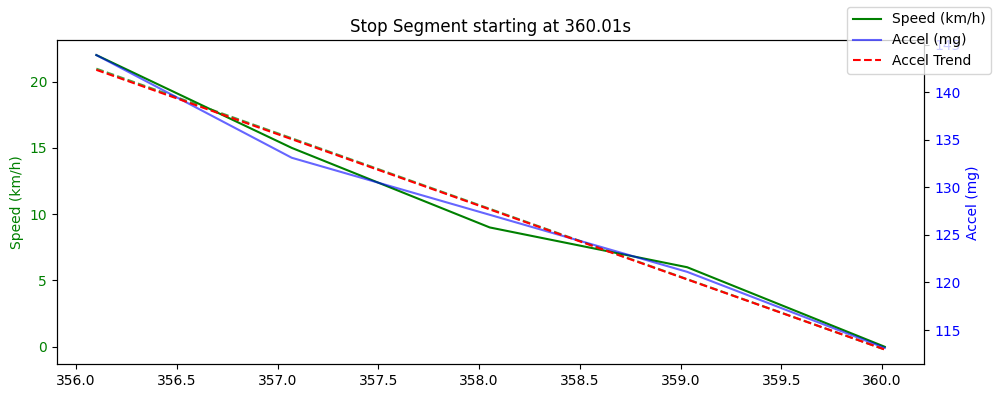

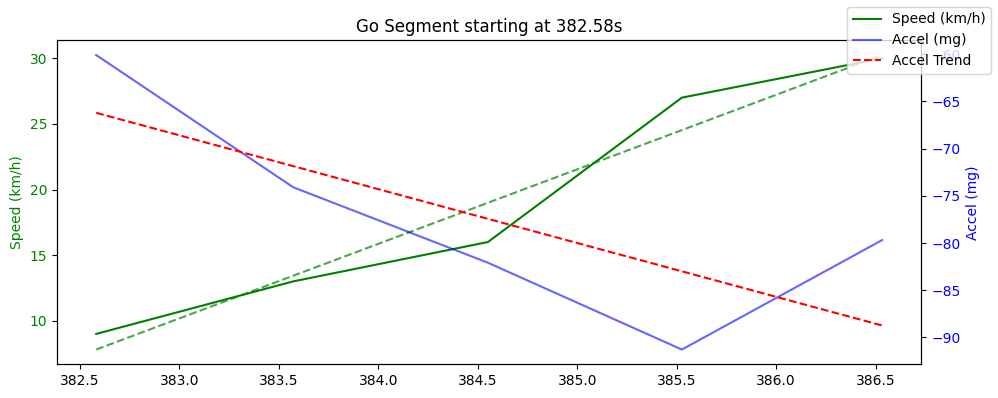

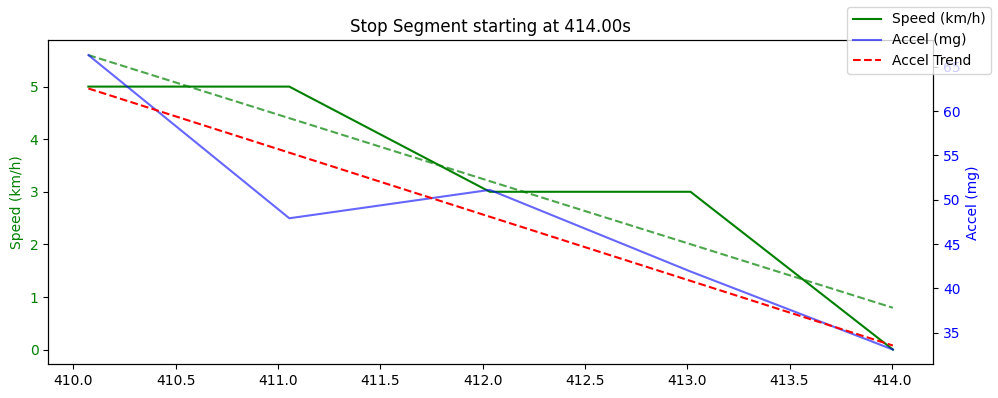

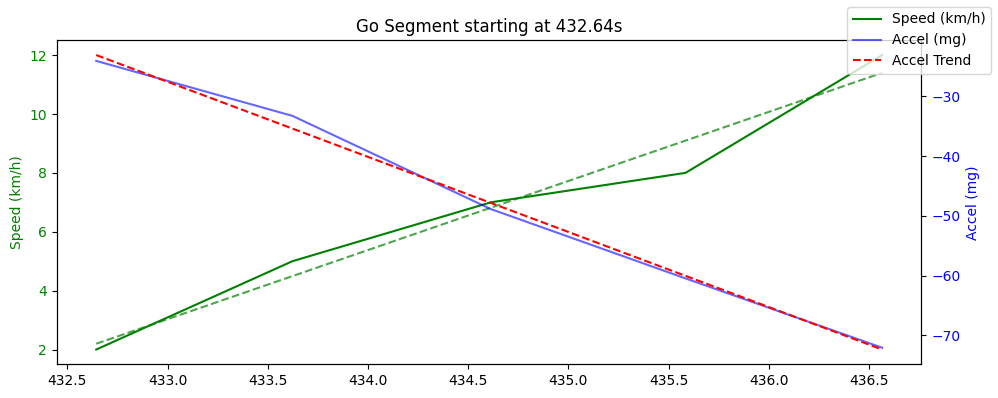

GO Segments:


,Type,Segment Start Time (s),Duration (s),Start Speed (km/h),End Speed (km/h),Start Accel (mg),End Accel (mg),Mean Accel (mg),Std Accel (mg)
0,Go,382.582,3.951,9.0,30.0,-60.083351,-79.683351,-77.443351,11.519028
1,Go,432.644,3.921,2.0,12.0,-24.083351,-72.083351,-47.763351,19.525163


STOP Segments:


,Type,Segment Start Time (s),Duration (s),Start Speed (km/h),End Speed (km/h),Start Accel (mg),End Accel (mg),Mean Accel (mg),Std Accel (mg)
0,Stop,360.014,3.914,22.0,0.0,143.916649,113.116649,127.676649,11.711874
1,Stop,414.005,3.932,5.0,0.0,66.316649,33.116649,48.076649,12.285276


In [50]:
def analyze_segment(segment, start_time, label, display_plots):
    duration = segment['Elapsed_s'].iloc[-1] - segment['Elapsed_s'].iloc[0]
    accel_mean = segment['X_centered'].mean()
    accel_std = segment['X_centered'].std()
    speed_start = segment['Speed_kmh'].iloc[0]
    speed_end = segment['Speed_kmh'].iloc[-1]
    accel_start = segment['X_centered'].iloc[0]
    accel_end = segment['X_centered'].iloc[-1]

    if display_plots:
        fig, ax1 = plt.subplots(figsize=(10, 4))
        ax2 = ax1.twinx()

        ax1.plot(segment['Elapsed_s'], segment['Speed_kmh'], 'g-', label='Speed (km/h)')
        ax1.set_ylabel('Speed (km/h)', color='g')
        ax1.tick_params(axis='y', labelcolor='g')

        ax2.plot(segment['Elapsed_s'], segment['X_centered'], 'b-', alpha=0.6, label='Accel (mg)')
        ax2.set_ylabel('Accel (mg)', color='b')
        ax2.tick_params(axis='y', labelcolor='b')

        if segment['Elapsed_s'].nunique() > 1:
            from scipy.stats import linregress
            slope_speed, intercept_speed, *_ = linregress(segment['Elapsed_s'], segment['Speed_kmh'])
            ax1.plot(segment['Elapsed_s'], slope_speed * segment['Elapsed_s'] + intercept_speed, 'g--', alpha=0.7)

            slope_accel, intercept_accel, *_ = linregress(segment['Elapsed_s'], segment['X_centered'])
            ax2.plot(segment['Elapsed_s'], slope_accel * segment['Elapsed_s'] + intercept_accel, 'r--', label='Accel Trend')

        plt.title(f"{label} Segment starting at {start_time:.2f}s")
        fig.tight_layout()
        fig.legend(loc='upper right')
        plt.show()

    return {
        'Type': label,
        'Segment Start Time (s)': start_time,
        'Duration (s)': duration,
        'Start Speed (km/h)': speed_start,
        'End Speed (km/h)': speed_end,
        'Start Accel (mg)': accel_start,
        'End Accel (mg)': accel_end,
        'Mean Accel (mg)': accel_mean,
        'Std Accel (mg)': accel_std
    }

def stop_and_go_analysis_v5(df, display_plots=True):
    """
    Analyze stop-and-go events.
    GO: From ~0 to motion
    STOP: From motion to ~0
    """
    go_summaries = []
    stop_summaries = []

    for i in range(1, len(df)):
        prev_speed = df.iloc[i - 1]['Speed_kmh']
        curr_speed = df.iloc[i]['Speed_kmh']
        curr_time = df.iloc[i]['Elapsed_s']

        # === GO Segment === (vehicle starts moving)
        if prev_speed <= 1.0 and curr_speed > 1.0:
            segment = df.iloc[i:i + 5].copy()
            if len(segment) > 1 and segment['Speed_kmh'].iloc[-1] > segment['Speed_kmh'].iloc[0]:
                go_summaries.append(analyze_segment(segment, curr_time, 'Go', display_plots))

        # === STOP Segment === (vehicle stops)
        if prev_speed > 1.0 and curr_speed <= 1.0:
            segment = df.iloc[max(0, i - 4):i + 1].copy()
            if len(segment) > 1 and segment['Speed_kmh'].iloc[-1] < segment['Speed_kmh'].iloc[0]:
                stop_summaries.append(analyze_segment(segment, curr_time, 'Stop', display_plots))

    return pd.DataFrame(go_summaries), pd.DataFrame(stop_summaries)

df_go, df_stop = stop_and_go_analysis_v5(dataset1)
print("GO Segments:")
display(df_go)
print("STOP Segments:")
display(df_stop)

In [51]:
print(dataset1.columns)
# Output: Index(['timestamp', 'velocity', ...], dtype='object')

Index(['Timestamp', 'Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'GPS_Fix',
       'Speed_kmh', 'Speed_Label', 'X_filt', 'X_centered', 'Elapsed_s',
       'Event'],
      dtype='object')


## Speed Controller Accuracy Analysis

This evaluates the performance of a vehicle's speed controller based on GPS speed data by:


### 1. **Segmenting Speed Profiles**
- Segments are split into:
  - **Over 50 mph** (`> 80.5 km/h`)
  - **Under 50 mph** (`≤ 80.5 km/h`)
- A new segment starts whenever the vehicle crosses the 50 mph threshold.


### 2. **Estimating Target Set Speed**
- Since the actual cruise control set speed is unknown, we estimate it dynamically using:
  - **Random Forest Regression**
  - Features used:
    - `Segment Duration`
    - `Speed Standard Deviation`
- The model predicts the most likely target set speed for each profile group.


### 3. **Calculating Accuracy**
Each segment's accuracy is calculated using the formula:

```
Accuracy (%) = 100 - (|Average Speed − Estimated Set Speed| / Estimated Set Speed) × 100
```

This measures how closely the vehicle maintains its speed relative to the estimated set speed.


### 4. **Visualisations**
- Line plots display speed trends for each segment.
- A **red dashed line** indicates the estimated set speed.
- Segment colors help identify transitions and behaviors over time.


### 5. **Summary Table**
Each segment is reported with the following metrics:

| Column                       | Description                               |
|-----------------------------|-------------------------------------------|
| Segment                     | Segment ID                                |
| Start Time (s)              | Beginning of the segment                  |
| End Time (s)                | End of the segment                        |
| Duration (s)                | Duration of the segment                   |
| Average Speed (km/h)        | Mean speed during the segment             |
| Speed Std Dev (km/h)        | Standard deviation of speed               |
| Set Speed Estimate (km/h)   | Predicted cruise control set speed        |
| Deviation from Set Speed    | Average Speed − Set Speed Estimate        |
| Accuracy (%)                | How close the segment stayed to the target|


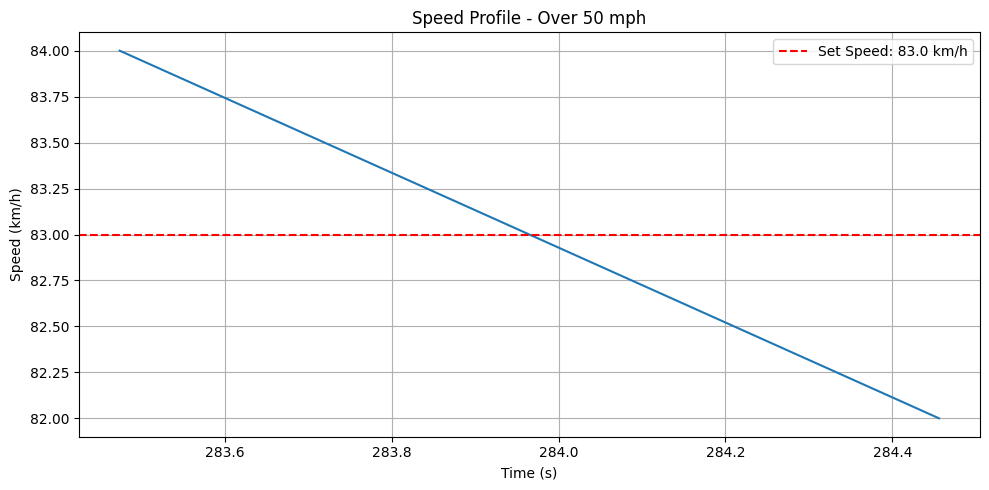

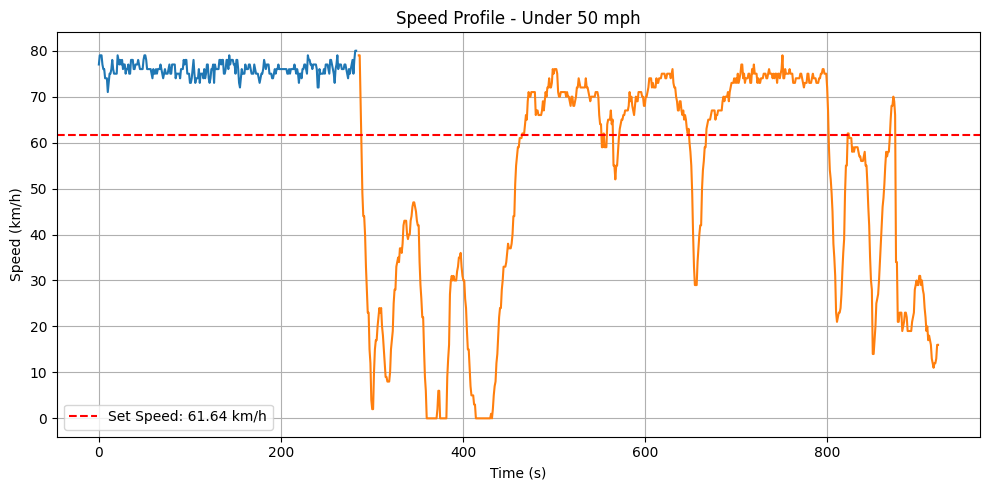


Over 50 mph Summary:


,Segment,Start Time (s),End Time (s),Duration (s),Average Speed (km/h),Speed Std Dev (km/h),Set Speed Estimate (km/h),Deviation from Set Speed,Accuracy (%)
0,1,283.474,284.456,0.982,83.0,1.414214,83.0,0.0,100.0



Under 50 mph Summary:


,Segment,Start Time (s),End Time (s),Duration (s),Average Speed (km/h),Speed Std Dev (km/h),Set Speed Estimate (km/h),Deviation from Set Speed,Accuracy (%)
0,0,0.000,282.504,282.504,75.968858,1.472809,61.64,14.328858,76.753961
1,2,285.441,921.491,636.050,49.910632,25.107141,61.64,-11.729368,80.971174


In [52]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.ticker as ticker

def speed_controller_accuracy(df, speed_col='Speed_kmh', time_col='Elapsed_s'):
    """
    Assess speed controller accuracy by segmenting data into over and under 50 mph profiles (80.5 km/h),
    estimating target set speed using Random Forest, and calculating deviation metrics.
    
    Parameters:
        df (pd.DataFrame): Full dataset with time and speed columns.
    
    Returns:
        dict: Summary statistics and visualizations for each profile.
    """
    df = df.copy()
    df = df.sort_values(by=time_col).reset_index(drop=True)
    threshold = 80.5  # 50 mph in km/h

    # Create profile label
    df['Profile'] = np.where(df[speed_col] > threshold, 'Over 50 mph', 'Under 50 mph')
    
    # Segment the profiles
    segments = []
    current_profile = df.loc[0, 'Profile']
    start_idx = 0

    for i in range(1, len(df)):
        if df.loc[i, 'Profile'] != current_profile:
            segment = df.iloc[start_idx:i].copy()
            segment['Segment'] = len(segments)
            segment['Profile'] = current_profile
            segments.append(segment)
            start_idx = i
            current_profile = df.loc[i, 'Profile']

    # Append the last segment
    final_segment = df.iloc[start_idx:].copy()
    final_segment['Segment'] = len(segments)
    final_segment['Profile'] = current_profile
    segments.append(final_segment)

    all_segments_df = pd.concat(segments, ignore_index=True)

    # Estimate set speed and compute metrics
    summary = {}
    for profile in ['Over 50 mph', 'Under 50 mph']:
        profile_df = all_segments_df[all_segments_df['Profile'] == profile]
        segment_stats = []

        for seg_id in profile_df['Segment'].unique():
            seg = profile_df[profile_df['Segment'] == seg_id]
            duration = seg[time_col].iloc[-1] - seg[time_col].iloc[0]
            avg_speed = seg[speed_col].mean()
            std_speed = seg[speed_col].std()
            segment_stats.append({
                'Segment': seg_id,
                'Start Time (s)': seg[time_col].iloc[0],
                'End Time (s)': seg[time_col].iloc[-1],
                'Duration (s)': duration,
                'Average Speed (km/h)': avg_speed,
                'Speed Std Dev (km/h)': std_speed
            })

        stats_df = pd.DataFrame(segment_stats)

        if not stats_df.empty:
            # Train Random Forest
            X = stats_df[['Duration (s)', 'Speed Std Dev (km/h)']]
            y = stats_df['Average Speed (km/h)']
            rf = RandomForestRegressor(n_estimators=100)
            rf.fit(X, y)
            predicted_set_speed = round(rf.predict([[X['Duration (s)'].mean(), X['Speed Std Dev (km/h)'].mean()]])[0], 2)

            # Add metrics
            stats_df['Set Speed Estimate (km/h)'] = predicted_set_speed
            stats_df['Deviation from Set Speed'] = stats_df['Average Speed (km/h)'] - predicted_set_speed
            stats_df['Accuracy (%)'] = 100 - (stats_df['Deviation from Set Speed'].abs() / predicted_set_speed * 100)

            # Plot
            plt.figure(figsize=(10, 5))
            sns.lineplot(data=profile_df, x=time_col, y=speed_col, hue='Segment', palette='tab10', legend=False)
            plt.axhline(predicted_set_speed, color='r', linestyle='--', label=f"Set Speed: {predicted_set_speed} km/h")
            plt.title(f"Speed Profile - {profile}")
            plt.xlabel("Time (s)")
            plt.ylabel("Speed (km/h)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        summary[profile] = stats_df

    return summary


# ========================
# Example usage:
# ========================

result = speed_controller_accuracy(dataset1, speed_col='Speed_kmh', time_col='Elapsed_s')

for profile, df in result.items():
    print(f"\n{profile} Summary:")
    display(df)  # works best in Jupyter or IPython environments



Over 50 mph Model Summary
R² Score for Over 50 mph: nan
Feature Importances (%):
  Duration (s): 0.0%
  Speed Std Dev (km/h): 0.0%


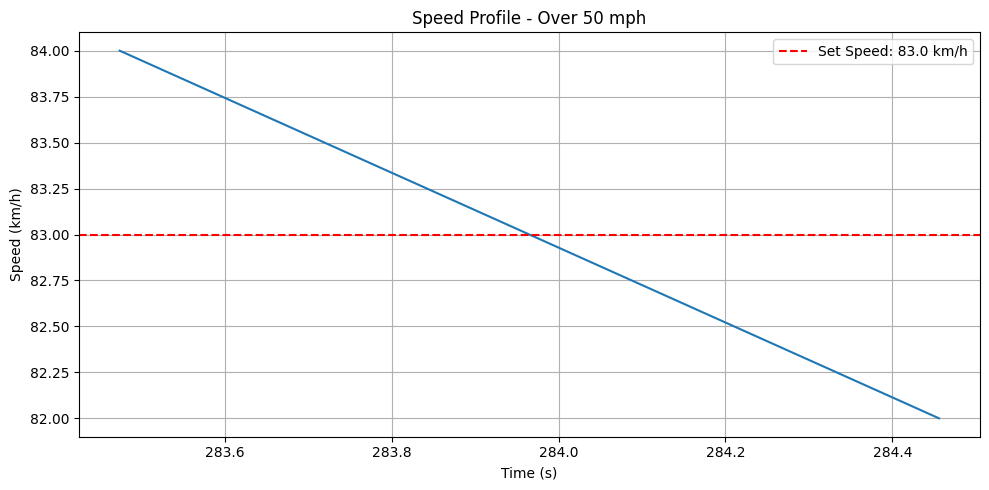


Under 50 mph Model Summary
R² Score for Under 50 mph: 0.7680
Feature Importances (%):
  Duration (s): 50.0%
  Speed Std Dev (km/h): 50.0%


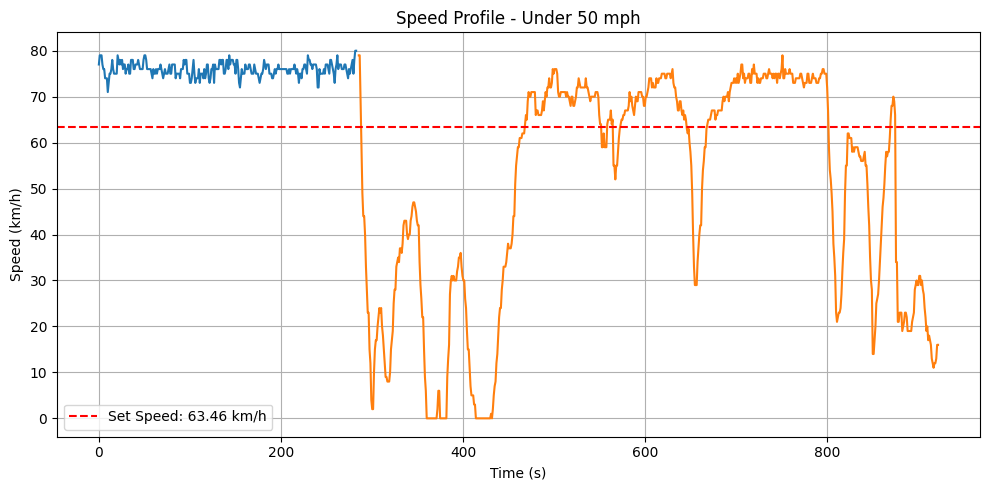


Over 50 mph Summary Table:


,Segment,Start Time (s),End Time (s),Duration (s),Average Speed (km/h),Speed Std Dev (km/h),Set Speed Estimate (km/h),Deviation from Set Speed,Accuracy (%)
0,1,283.474,284.456,0.982,83.0,1.414214,83.0,0.0,100.0



Under 50 mph Summary Table:


,Segment,Start Time (s),End Time (s),Duration (s),Average Speed (km/h),Speed Std Dev (km/h),Set Speed Estimate (km/h),Deviation from Set Speed,Accuracy (%)
0,0,0.000,282.504,282.504,75.968858,1.472809,63.46,12.508858,80.288594
1,2,285.441,921.491,636.050,49.910632,25.107141,63.46,-13.549368,78.648963


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def speed_controller_accuracy(df, speed_col='Speed_kmh', time_col='Elapsed_s'):
    """
    Assess speed controller accuracy by segmenting data into over and under 50 mph profiles (80.5 km/h),
    estimating target set speed using Random Forest, and calculating deviation metrics.

    Parameters:
        df (pd.DataFrame): Full dataset with time and speed columns.

    Returns:
        dict: Summary statistics and visualizations for each profile.
    """
    df = df.copy()
    df = df.sort_values(by=time_col).reset_index(drop=True)
    threshold = 80.5  # 50 mph in km/h

    # Create profile label
    df['Profile'] = np.where(df[speed_col] > threshold, 'Over 50 mph', 'Under 50 mph')
    
    # Segment the profiles
    segments = []
    current_profile = df.loc[0, 'Profile']
    start_idx = 0

    for i in range(1, len(df)):
        if df.loc[i, 'Profile'] != current_profile:
            segment = df.iloc[start_idx:i].copy()
            segment['Segment'] = len(segments)
            segment['Profile'] = current_profile
            segments.append(segment)
            start_idx = i
            current_profile = df.loc[i, 'Profile']

    # Append the last segment
    final_segment = df.iloc[start_idx:].copy()
    final_segment['Segment'] = len(segments)
    final_segment['Profile'] = current_profile
    segments.append(final_segment)

    all_segments_df = pd.concat(segments, ignore_index=True)

    # Estimate set speed and compute metrics
    summary = {}
    for profile in ['Over 50 mph', 'Under 50 mph']:
        profile_df = all_segments_df[all_segments_df['Profile'] == profile]
        segment_stats = []

        for seg_id in profile_df['Segment'].unique():
            seg = profile_df[profile_df['Segment'] == seg_id]
            duration = seg[time_col].iloc[-1] - seg[time_col].iloc[0]
            avg_speed = seg[speed_col].mean()
            std_speed = seg[speed_col].std()
            segment_stats.append({
                'Segment': seg_id,
                'Start Time (s)': seg[time_col].iloc[0],
                'End Time (s)': seg[time_col].iloc[-1],
                'Duration (s)': duration,
                'Average Speed (km/h)': avg_speed,
                'Speed Std Dev (km/h)': std_speed
            })

        stats_df = pd.DataFrame(segment_stats)

        if not stats_df.empty:
            # Train Random Forest
            X = stats_df[['Duration (s)', 'Speed Std Dev (km/h)']]
            y = stats_df['Average Speed (km/h)']
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X, y)
            y_pred = rf.predict(X)
            predicted_set_speed = round(rf.predict([[X['Duration (s)'].mean(), X['Speed Std Dev (km/h)'].mean()]])[0], 2)

            # Feature importances
            importances = rf.feature_importances_
            importance_dict = {
                'Feature Importances': {
                    'Duration (s)': round(importances[0] * 100, 2),
                    'Speed Std Dev (km/h)': round(importances[1] * 100, 2)
                }
            }

            # Accuracy (R^2 score)
            r2 = r2_score(y, y_pred)
            model_accuracy_note = f"R² Score for {profile}: {r2:.4f}"

            # Add metrics
            stats_df['Set Speed Estimate (km/h)'] = predicted_set_speed
            stats_df['Deviation from Set Speed'] = stats_df['Average Speed (km/h)'] - predicted_set_speed
            stats_df['Accuracy (%)'] = 100 - (stats_df['Deviation from Set Speed'].abs() / predicted_set_speed * 100)

            # Display metrics
            print(f"\n{profile} Model Summary")
            print(model_accuracy_note)
            print("Feature Importances (%):")
            for k, v in importance_dict['Feature Importances'].items():
                print(f"  {k}: {v}%")

            # Plot
            plt.figure(figsize=(10, 5))
            sns.lineplot(data=profile_df, x=time_col, y=speed_col, hue='Segment', palette='tab10', legend=False)
            plt.axhline(predicted_set_speed, color='r', linestyle='--', label=f"Set Speed: {predicted_set_speed} km/h")
            plt.title(f"Speed Profile - {profile}")
            plt.xlabel("Time (s)")
            plt.ylabel("Speed (km/h)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        summary[profile] = stats_df

    return summary


# ========================
# Example usage:
# ========================

result = speed_controller_accuracy(dataset1, speed_col='Speed_kmh', time_col='Elapsed_s')

for profile, df in result.items():
    print(f"\n{profile} Summary Table:")
    display(df)


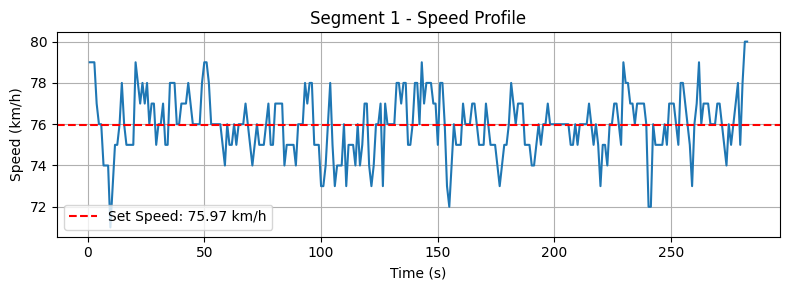

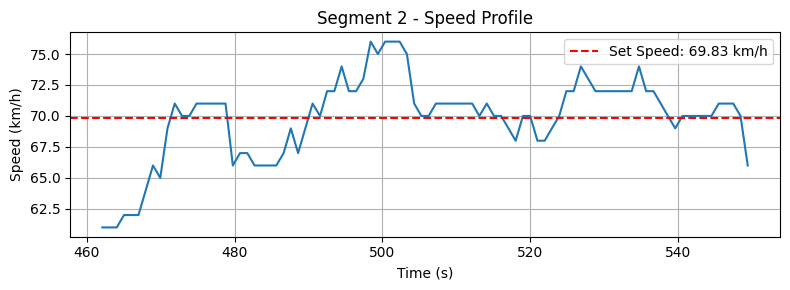

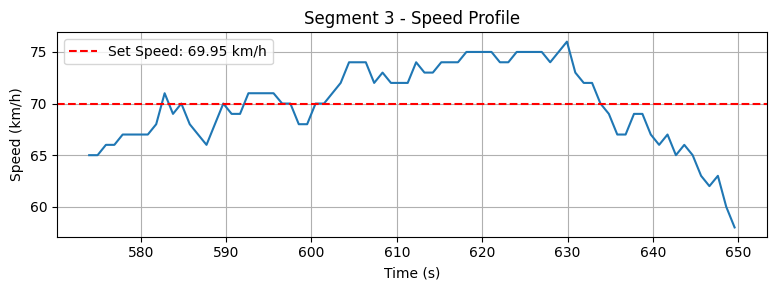

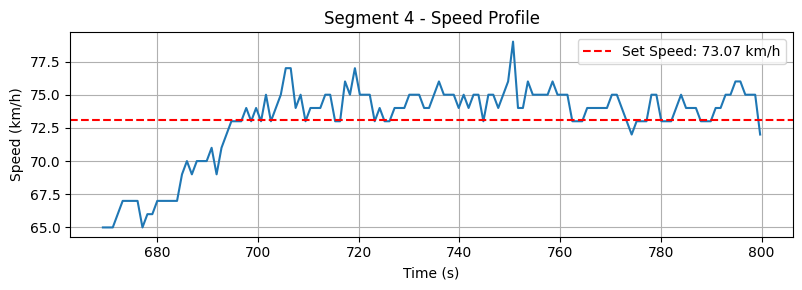

Summary of Speed Controller Accuracy per Stable Segment:


,Segment,Start Time (s),End Time (s),Duration (s),Average Speed (km/h),Speed Std Dev (km/h),Set Speed Estimate (km/h),Deviation (km/h),Accuracy (%)
0,1,0.97,283.47,281.53,75.97,1.47,75.97,-0.0047,99.9938
1,2,462.11,550.42,87.32,69.83,3.34,69.83,0.0033,99.9952
2,3,573.97,650.55,75.60,69.95,3.92,69.95,-0.0013,99.9982
3,4,669.19,800.70,130.52,73.07,2.95,73.07,-0.0028,99.9961


In [54]:
def speed_controller_accuracy_per_segment(segments, speed_col='Speed_kmh', time_col='Elapsed_s'):
    """
    Assess speed controller accuracy for each individual stable segment using Random Forest.

    Parameters:
        segments (list): Output from find_dynamic_stable_speed_segments
        speed_col (str): Speed column name
        time_col (str): Time column name

    Returns:
        pd.DataFrame: Summary table with per-segment performance.
    """
    results = []

    for i, (start_time, end_time, seg_df) in enumerate(segments):
        df = seg_df.copy().sort_values(by=time_col).reset_index(drop=True)

        if len(df) < 10:
            continue  # Skip very short segments

        duration = df[time_col].iloc[-1] - df[time_col].iloc[0]
        avg_speed = df[speed_col].mean()
        std_speed = df[speed_col].std()

        # Prepare training data for this single segment (just one row)
        X = pd.DataFrame({
            'Duration (s)': [duration],
            'Speed Std Dev (km/h)': [std_speed]
        })
        y = [avg_speed]

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        predicted_set_speed = round(rf.predict(X)[0], 2)
        deviation = avg_speed - predicted_set_speed
        accuracy = 100 - abs(deviation) / predicted_set_speed * 100

        # Store results
        results.append({
            'Segment': i + 1,
            'Start Time (s)': round(start_time, 2),
            'End Time (s)': round(end_time, 2),
            'Duration (s)': round(duration, 2),
            'Average Speed (km/h)': round(avg_speed, 2),
            'Speed Std Dev (km/h)': round(std_speed, 2),
            'Set Speed Estimate (km/h)': predicted_set_speed,
            'Deviation (km/h)': round(deviation, 4),
            'Accuracy (%)': round(accuracy, 4)
        })

        # Plot speed for the segment
        plt.figure(figsize=(8, 3))
        sns.lineplot(data=df, x=time_col, y=speed_col)
        plt.axhline(predicted_set_speed, color='r', linestyle='--', label=f"Set Speed: {predicted_set_speed} km/h")
        plt.title(f"Segment {i+1} - Speed Profile")
        plt.xlabel("Time (s)")
        plt.ylabel("Speed (km/h)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

# ========================
# Example usage:
# ========================
segments = find_dynamic_stable_speed_segments(
    dataset1,
    rolling_window=5,
    std_threshold=3.0,
    min_duration=30
)

result_df = speed_controller_accuracy_per_segment(segments, speed_col='Speed_kmh', time_col='Elapsed_s')

# Display result table
print("Summary of Speed Controller Accuracy per Stable Segment:")
display(result_df)
